## `ShakeNBreak` applied to Cd vacancies in CdTe ($V_{Cd}$)

In this notebook we follow the full `ShakeNBreak` (`SnB`) workflow, where we:
- Apply the defect distortions
- Parse the geometry relaxation results
- Re-generate any energy-lowering distortions found for _some_ (but not all) charge states for a given defect
- Plot the final energies to demonstrate what energy-lowering defect distortions have been identified
- Then continue our defect calculations, confident we have obtained the ground-state structures. 

### Table of contents
* [Generate defects with doped/pymatgen](#generate)
* [Apply SnB to defects](#SnB)
* [Send to HPCs and run calculations](#HPCs)
* [Plot energies of final structures](#plot)
* [Analyse defect distortions](#analyse)

In [1]:
import sys
import os
import doped
import pymatgen
import ase
import shakenbreak
import numpy as np
from importlib.metadata import version

# check versions
print("Doped version:" , version('doped') )
print("Pymatgen version:" , version('pymatgen') )
print("Ase version:" , version('ase') )
# print("ShakeNBreak version:" , version('shakenbreak') )

Doped version: 0.0.7
Pymatgen version: 2022.3.29
Ase version: 3.22.1


<a id='generate'></a>

#### 1. Generate defects with `doped`/`pymatgen`

In [2]:
from doped.pycdt.core.defectsmaker import ChargedDefectsStructures
from pymatgen.core.structure import Structure

# Specify perfect (bulk) supercell structure
bulk_supercell = Structure.from_file("./data/CdTe_Bulk_Supercell_POSCAR")  

# Let's generate the vacancies
def_structs = ChargedDefectsStructures(
    bulk_supercell,
    cellmax=bulk_supercell.num_sites,
    antisites_flag=False,
    include_interstitials=False,
)

Setting up vacancies

Number of jobs created:
    bulk = 1
    vacancies:
        vac_1_Cd = 5 with site multiplicity 32
        vac_2_Te = 5 with site multiplicity 32
    substitutions:
Total (non dielectric) jobs created = 11



In [3]:
defect_dict = def_structs.defects
# only using these species for example purpose:
V_Cd_dict = {"vacancies": [defect_dict["vacancies"][0]]}
V_Cd_dict["vacancies"][0]["charges"] = [-2, -1, 0]  

##### Rationale for `SnB`   

Defect distortions often follow the change in electron count when introducing that defect to the system. For the neutral Cd vacancy ($V_{Cd}^0$) for example, the removal of Cd and its two valence electrons means that local distortions are likely to involve two neighbouring Te atoms moving closer/further apart to accommodate the broken bonds. For the singly-charged vacancy, we are likely to have just one neighbouring Te moving, etc.

So, the `SnB` method involves distorting the initial bond lengths around the defect for a mesh of trial distortions, with the number of neighbours to distort dictated by the change in valence electron count, performing coarse $\Gamma$-only (`vasp_gam`) relaxations and then comparing the final energies, to see if we identify any lower energy defect structures.

#### 2. Apply the `SnB` method to your defects

<a id='SnB'></a>

The default settings and parameter choices in this package have been tested and have performed best thus far (i.e. wider distortion ranges leading to the ground-state structure with lowest computational cost) – this data will be shown in an forthcoming publication. 

If you encounter improved performance with non-default parameter choices, we'd love to know! Please get in touch via GitHub or by email: sean.kavanagh.19@ucl.ac.uk & i.mosquera-lois22@imperial.ac.uk

##### A Note for Hard / Ionic / Oxide / Close-Packed / Small Bond Length (< 2.5 Å) Systems:

> The standard deviation (`std_dev`) controls the magnitude of the random perturbations applied to the structures. For materials with bond distances in the range ~2.5 - 3.5 Å, the default `std_dev` of 0.25 Å seems to perform best. However, for some strongly-bonded systems it may be too much. 

> If this is the case, it will manifest as high energies for the distorted structures compared to the unperturbed relaxation. If you know your system meets these criteria, you should set `std_dev` = 0.15 Å in `apply_shakenbreak()` below, and `bond_distortions = np.arange(-0.5, 0.501, 0.1)` (default range of ±0.6 too large). 
If you are unsure but suspect this could be an issue for your material, the best strategy is often to begin with the default settings, and then monitor the results of the first few distortion meshes that run; if the final energies are less than or equal to the unperturbed relaxation, then no need to change. Otherwise, you should reduce `std_dev` to 0.15 Å (or 0.05 Å if this choice still causes higher energies). More info on this is given later on.

##### Generating distorted structures

In [4]:
from shakenbreak import input, energy_lowering_distortions
from shakenbreak.input import Distortions

In [5]:
# In order to determine the number of the defect nearest neighbours to distort 
# (based on the change in valence electrons mentioned above), we input the oxidation states 
# of the atoms in our material:
oxidation_states = {"Cd": +2, "Te": -2}  # specify atom oxidation states

# Create an instance of Distortion class with the defect dictionary and the distortion parameters
# If distortion parameters are not specified, the default values are used
Dist = Distortions( 
            defects_dict=dict(V_Cd_dict), 
            oxidation_states=oxidation_states, 
            )

In [6]:
# We can check the distortion parameters using some of the class properties
print("Bond distortions:", Dist.bond_distortions)
print("Rattle standard deviation:", Dist.stdev, "A")

Bond distortions: [-0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
Rattle standard deviation: 0.25 A


In [7]:
# You can restrict the ions that are distorted to a certain element using the keyword distorted_elements
# We can check it using the class attribute
print("User defined elements to distort:", Dist.distorted_elements)
# If None, it means no restrictions so nearest neighbours are distorted

User defined elements to distort: None


To see the optional parameters that can be tuned in the distortion functions, look at the docstrings:

In [8]:
input.Distortions?

Init signature:
input.Distortions(
    defects_dict: dict,
    oxidation_states: dict,
    dict_number_electrons_user: Union[dict, NoneType] = None,
    distortion_increment: float = 0.1,
    bond_distortions: Union[list, NoneType] = None,
    stdev: float = 0.25,
    distorted_elements: Union[dict, NoneType] = None,
    **kwargs,
)
Docstring:     
Class to apply rattle and bond distortion to all defects in `defects_dict` (in `doped`
`ChargedDefectsStructures()` format).
Init docstring:
Setup the distortion parameters
Args:
    defects_dict (:obj:`dict`):
        Dictionary of defects as generated with `doped` `ChargedDefectsStructures()`
    oxidation_states (:obj:`dict`):
        Dictionary of oxidation states for species in your material, used to determine the
        number of defect neighbours to distort (e.g {"Cd": +2, "Te": -2}).
    dict_number_electrons_user (:obj:`dict`):
        Optional argument to set the number of extra/missing charge (negative of electron count
        c

If we're only interested in generating distorted structures, but not in writting `VASP`/other codes input files, we can use the class method `Distortions.apply_distortions()` to do this.

In [9]:
# defects_dict, distortion_metadata = Dist.apply_distortions()

In [10]:
# defects_dict["vac_1_Cd"].keys()

If we want to generate `VASP`/other codes input files, we can use the class method `Distortions.write_vasp_files()`.

In [11]:
# Dist.write_vasp_files()

In [12]:
Dist.write_qe_files()

Applying ShakeNBreak... Will apply the following bond distortions: ['-0.6', '-0.5', '-0.4', '-0.3', '-0.2', '-0.1', '0.0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6']. Then, will rattle with a std dev of 0.25 Å 


Defect: vac_1_Cd
Number of missing electrons in neutral state: 2

Defect vac_1_Cd in charge state: -2. Number of distorted neighbours: 0

Defect vac_1_Cd in charge state: -1. Number of distorted neighbours: 1

Defect vac_1_Cd in charge state: 0. Number of distorted neighbours: 2


Using `incar_settings` above, we can specify some custom `INCAR` tags to match our converged `ENCUT` for this system and optimal `NCORE` for the HPC we will run the calculations on. More information on the distortions generated can be obtained by setting `verbose = True`.

Our distorted structures and VASP input files have now been generated in the `vac_1_Cd_X` folders.

And for the default coarse structure-searching `INCAR` settings, have a look at the generated files:

In [12]:
!cat vac_1_Cd_-1/Bond_Distortion_-10.0%/INCAR

cat: vac_1_Cd_-1/Bond_Distortion_-10.0%/INCAR: No such file or directory


Note that the `NELECT` `INCAR` tag (number of electrons) is automatically determined based on the choice of `POTCAR`s. The default in `ShakeNBreak` is to use the `MPRelaxSet` `POTCAR` choices, but if you're using different ones, make sure to set `potcar_settings` in `apply_shakenbreak()`, so that NELECT is then set accordingly. Note this relies on you having set up `pymatgen` to work with your `POTCAR`s via the `~/.pmgrc.yaml` file, instructions [here](https://pymatgen.org/installation.html#potcar-setup)

<a id='HPCs'></a>

#### 3. Send to HPCs and run relaxations
Then parse the energies by running the `parse_SnB` command from the top-level folder containing your defect folders (e.g. `vac_1_Cd_0` etc. (with subfolders: `vac_1_Cd_0/Bond_Distortion_10.0%` etc.)). This will parse the energies and store them in a `vac_1_Cd_0.txt` etc file in the defect folders, to allow easy plotting and analysis.

It is also recommended to parse the final structures (`CONTCAR`s) obtained with each distortion relaxation for further structural analysis. 

Copying these data to your local PC can be done quickly from your local folder top-level folder (containing `vac_1_Cd_0` etc) with the following code:

```bash
for defect in ./*{_,_-}[0-9]/; do cd $defect; scp {remote_machine}:{path to ShakeNBreak folders}/${defect}${defect%?}.txt .; for distortion in (Bond_Distortion|Unperturbed|Rattled)*/; do scp {remote_machine}:{path to ShakeNBreak folders}/${defect}${distortion}CONTCAR ${distortion}; done; cd ..; done
```
making sure to change `{remote_machine}` and `{path to ShakeNBreak folders}` to the correct values in your case.

**_For demonstration purposes_** in this example notebook, we'll use some (fake) example data:  
(Don't do this if you're actually running the calculations and have downloaded the data as instructed above)

In [11]:
!cp -r data/example_results/* .  
# may need to change path if you've moved the example notebook elsewhere

<a id='plot'></a>

#### 4. Plot energies vs distortion
To see if `SnB` found any energy-lowering distortions, we can plot the results using the functions in `shakenbreak.plotting`.

In [8]:
from shakenbreak import energy_lowering_distortions, plotting

In [9]:
defect_charges_dict = energy_lowering_distortions.read_defects_directories()
low_energy_defects = energy_lowering_distortions.get_energy_lowering_distortions(
    defect_charges_dict)


vac_1_Cd
No energy lowering distortion with energy difference greater than min_e_diff = 0.05 eV found for vac_1_Cd with charge -2.
vac_1_Cd_0: Energy difference between minimum, found with -0.6 bond distortion, and unperturbed: -0.76 eV.
Energy lowering distortion found for vac_1_Cd with charge 0. Adding to low_energy_defects dictionary.
vac_1_Cd_-1: Energy difference between minimum, found with 0.2 bond distortion, and unperturbed: -0.90 eV.
Comparing structures to specified ref_structure (Cd31 Te32)...
New (according to structure matching) low-energy distorted structure found for vac_1_Cd_-1, adding to low_energy_defects['vac_1_Cd'] list.

Comparing and pruning defect structures across charge states...
Comparing structures to specified ref_structure (Cd31 Te32)...
Comparing structures to specified ref_structure (Cd31 Te32)...
Comparing structures to specified ref_structure (Cd31 Te32)...
Comparing structures to specified ref_structure (Cd31 Te32)...


These functions give us some info about whether any energy-lowering defect distortions were identified, and we can see the results clearer by plotting:

Plot saved to /Users/skavanagh/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Bread/Projects/Packages/ShakeNBreak/distortion_plots/
Plot saved to /Users/skavanagh/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Bread/Projects/Packages/ShakeNBreak/distortion_plots/


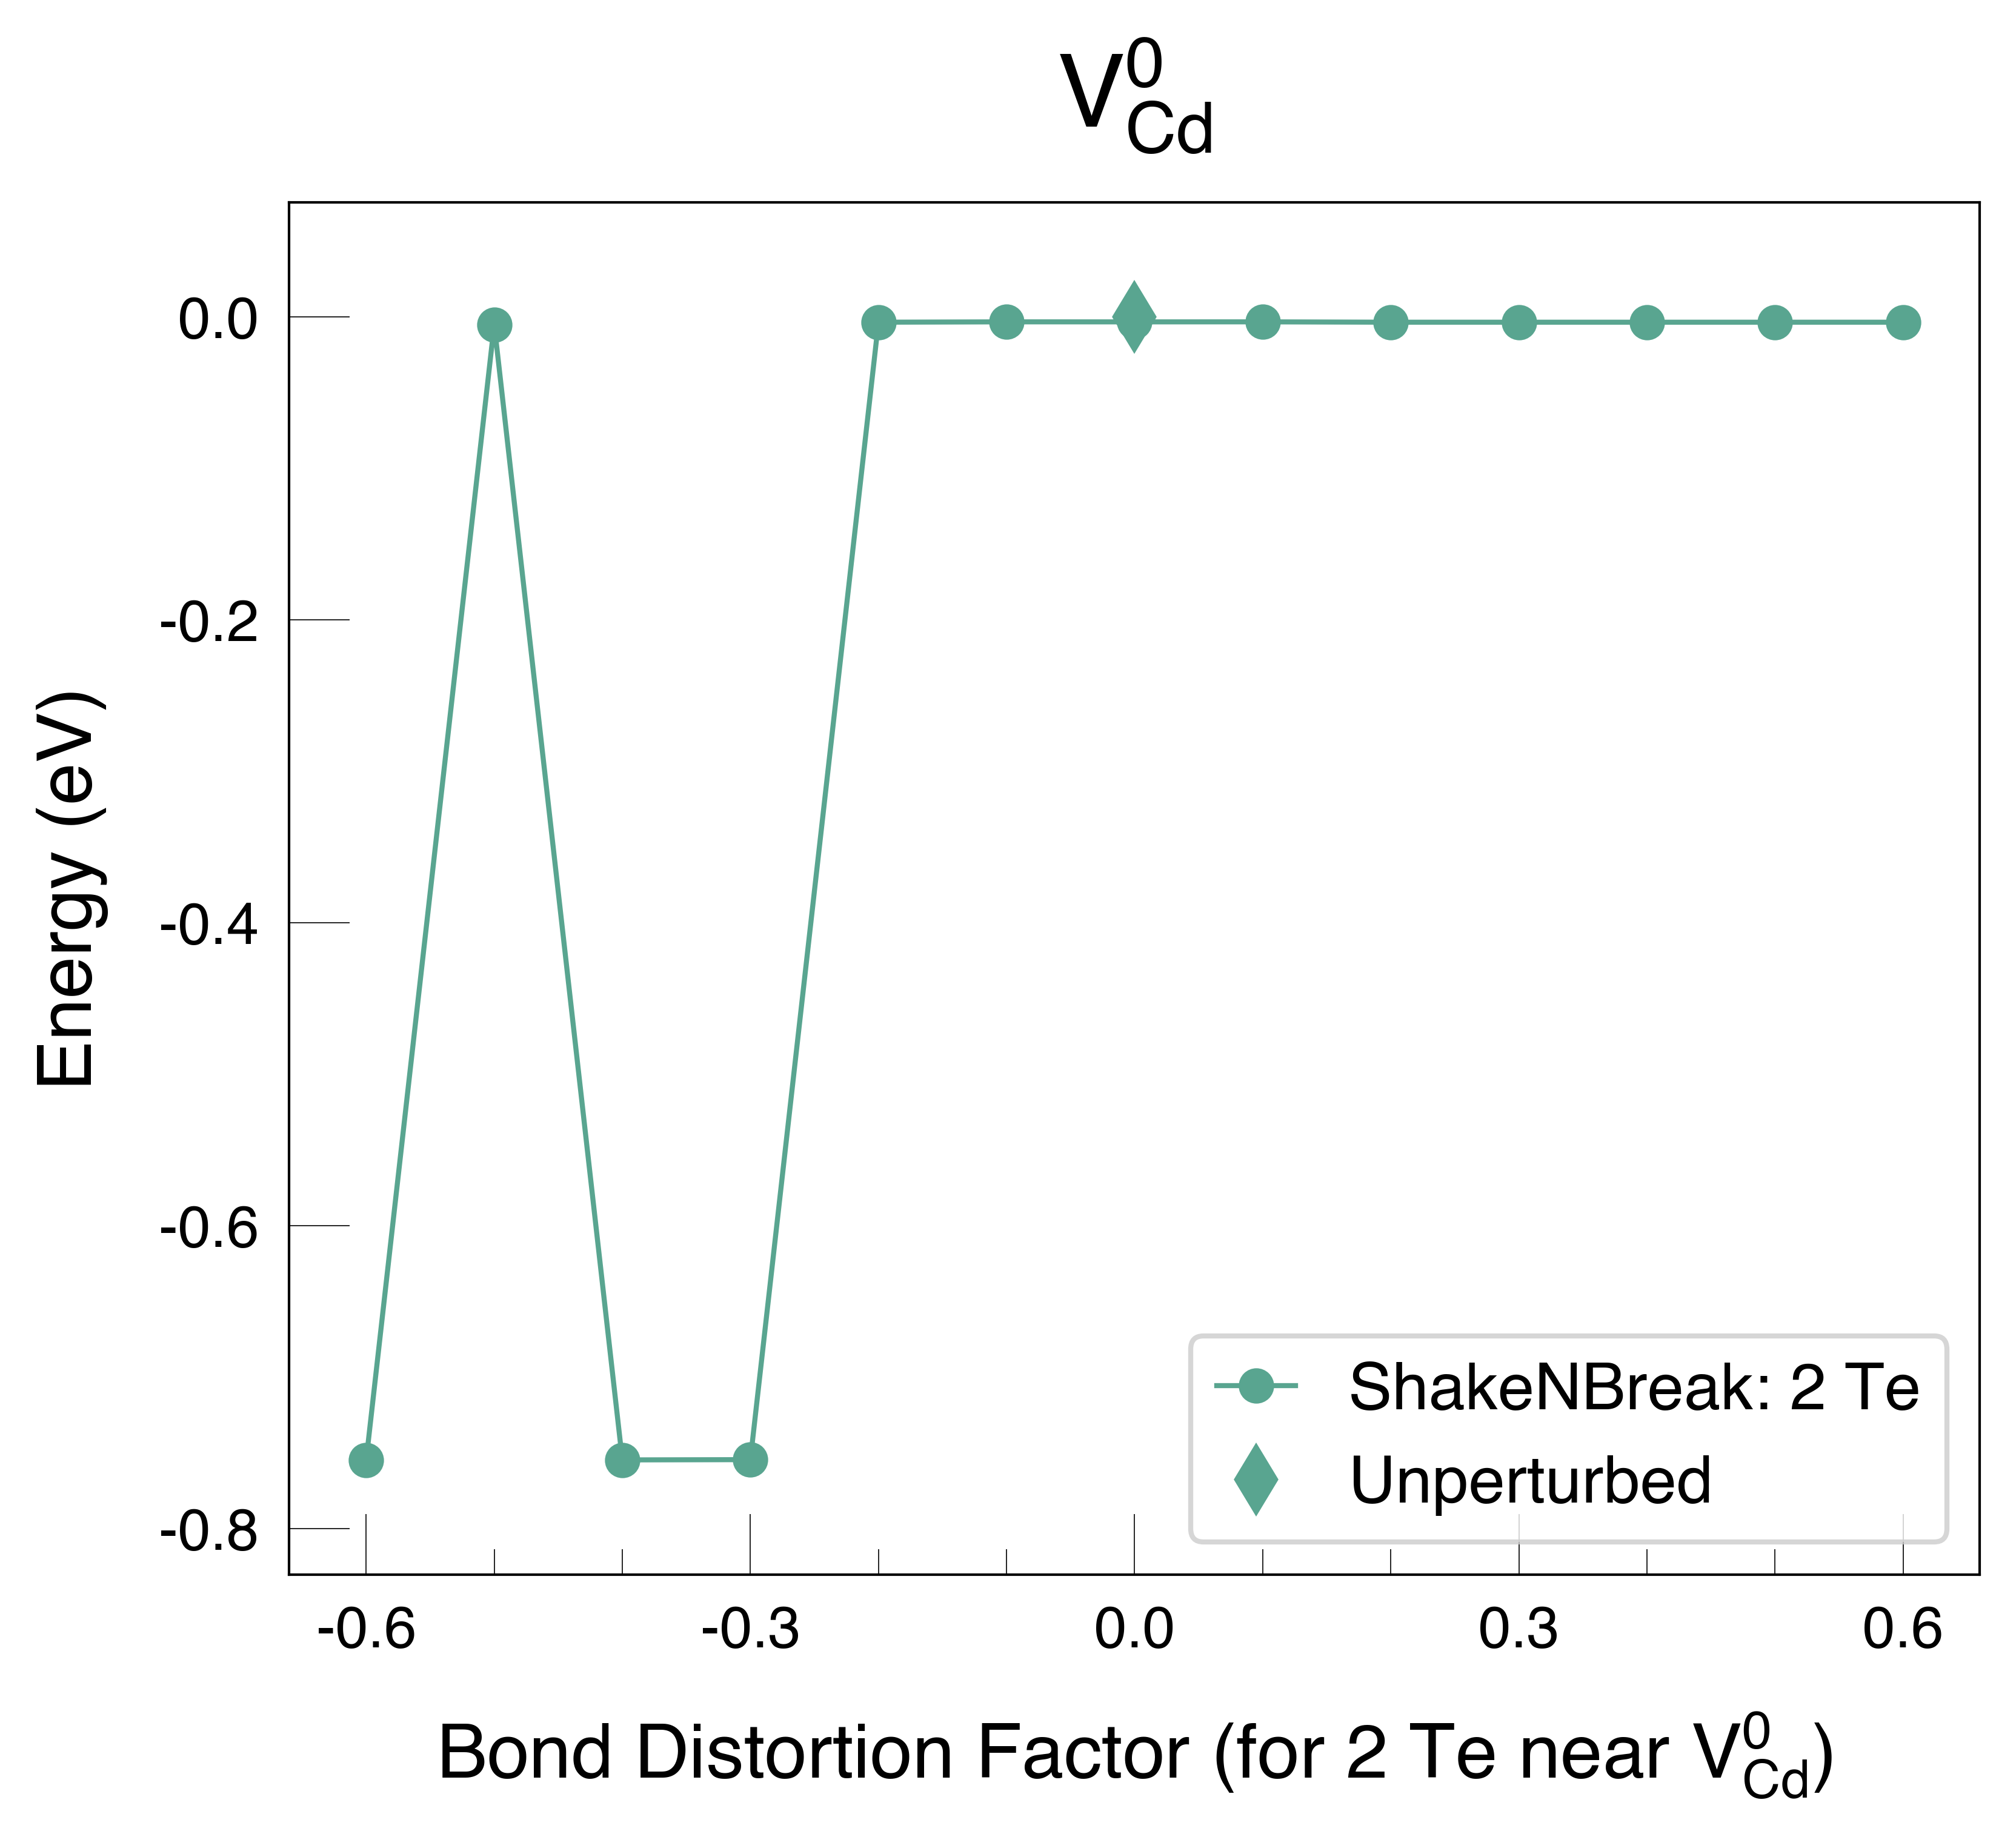

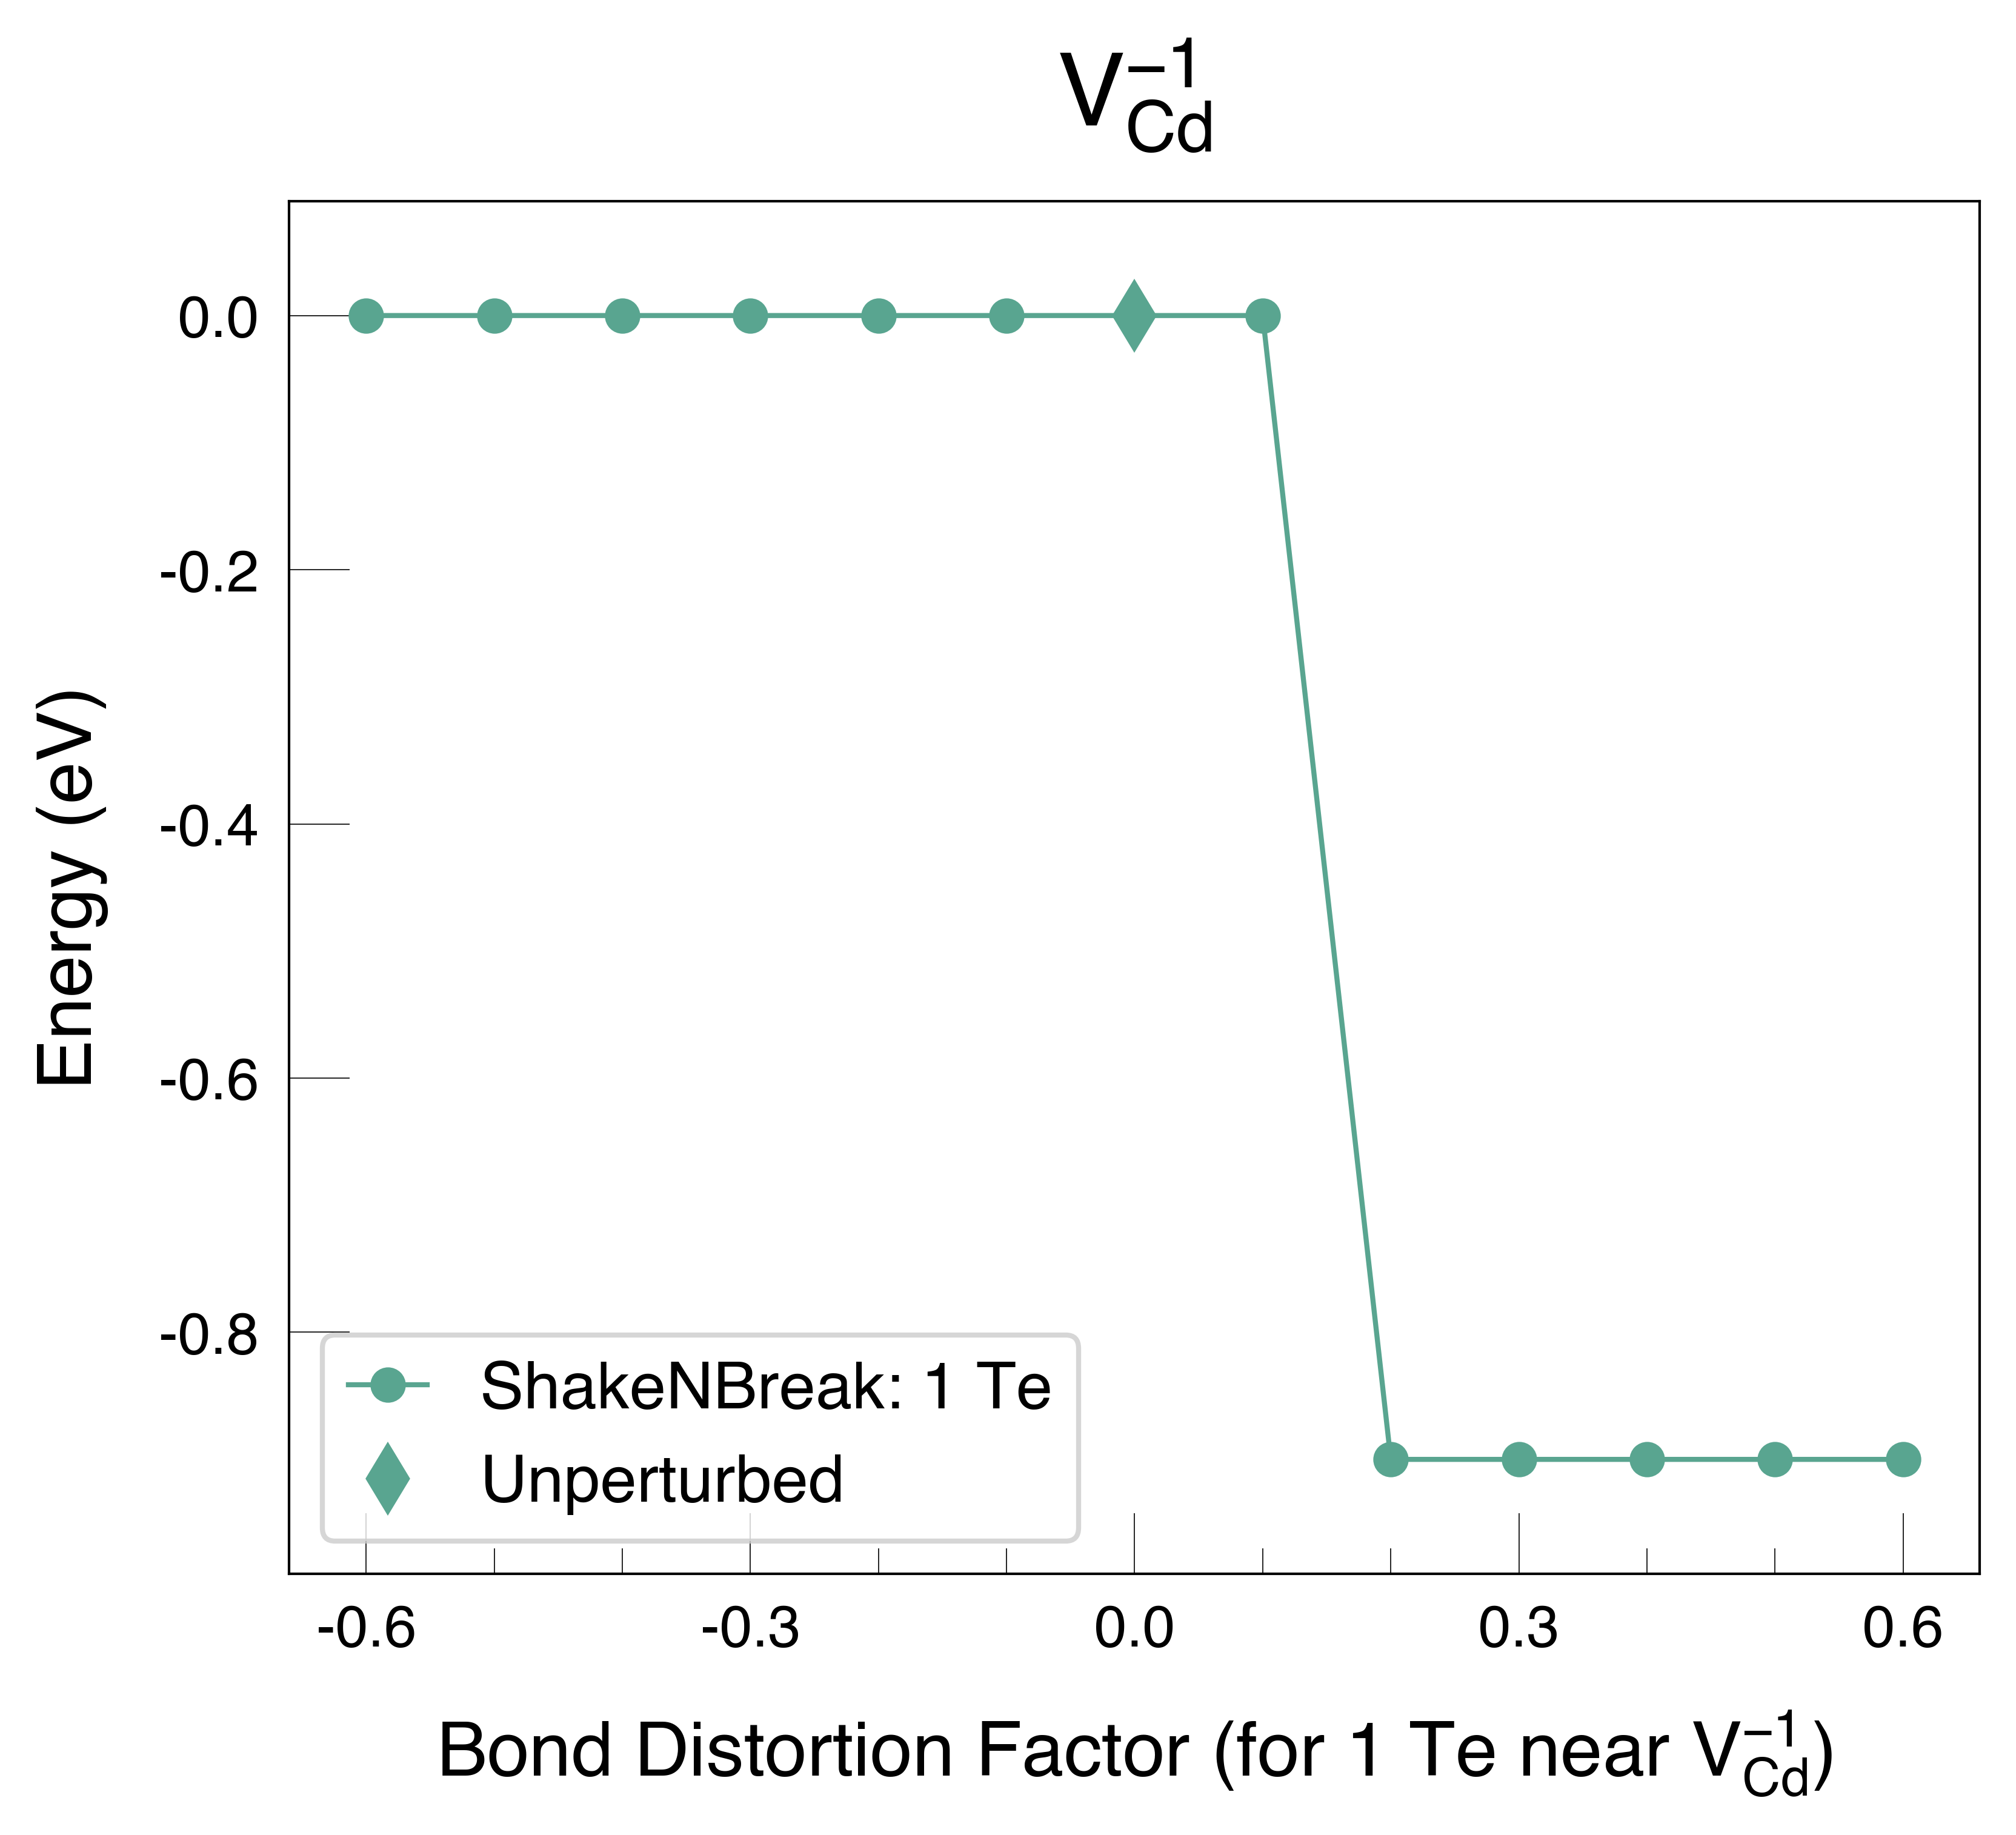

In [10]:
figs = plotting.plot_all_defects(defect_charges_dict)

This prints the distortion plots for all defects where a significant energy lowering distortion, relative to the standard unperturbed relaxation, was identified. The threshold energy difference to consider as 'significant' is controlled by the `min_e_diff` optional parameter (default = 0.05 eV).

##### Can also add a colorbar 
These plots can be made more informative by adding a colorbar showing the structural similarity between the relaxed structures.   
For this you need the `CONTCAR`'s obtained with each distortion (as mentioned above).

For the colorbar structure comparison metric, you can either use:
* summed root mean squared displacement (`metric` = `disp`)
* maximum distance between matching sites (`metric` = `max_dist`, default).   

Comparing structures to Unperturbed...
Plot saved to /Users/skavanagh/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Bread/Projects/Packages/ShakeNBreak/distortion_plots/
Comparing structures to Unperturbed...
Plot saved to /Users/skavanagh/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Bread/Projects/Packages/ShakeNBreak/distortion_plots/


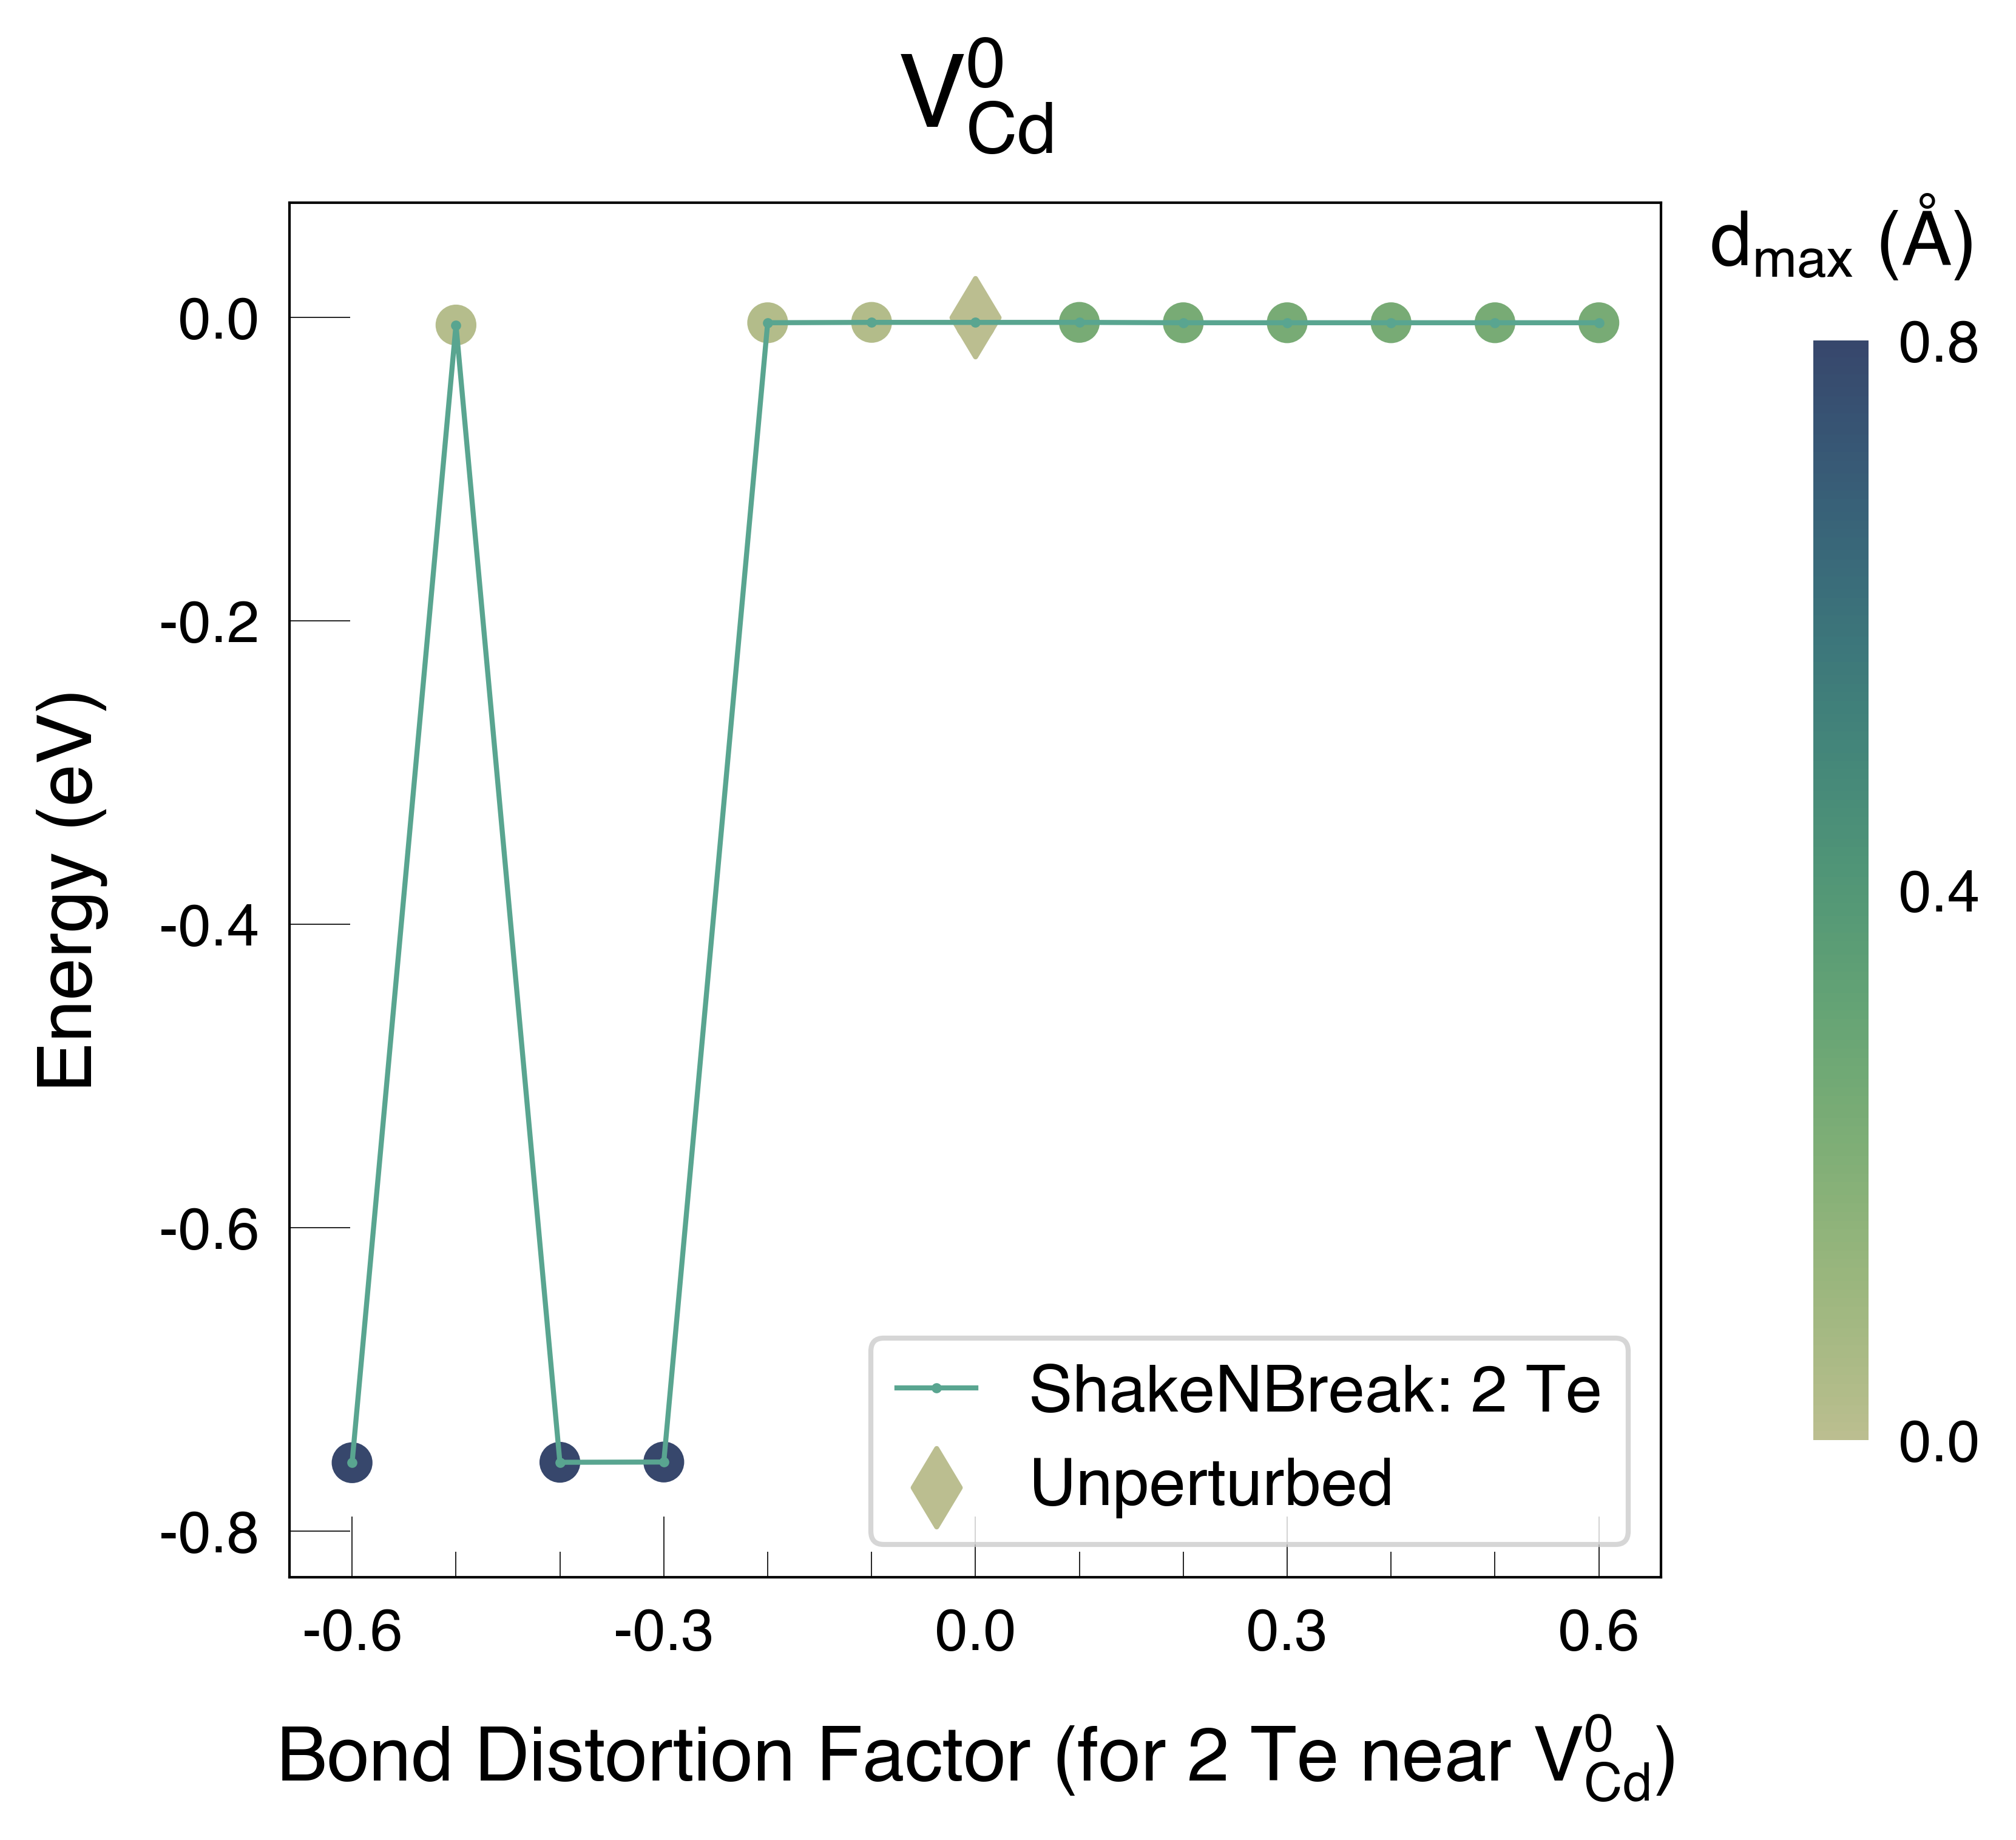

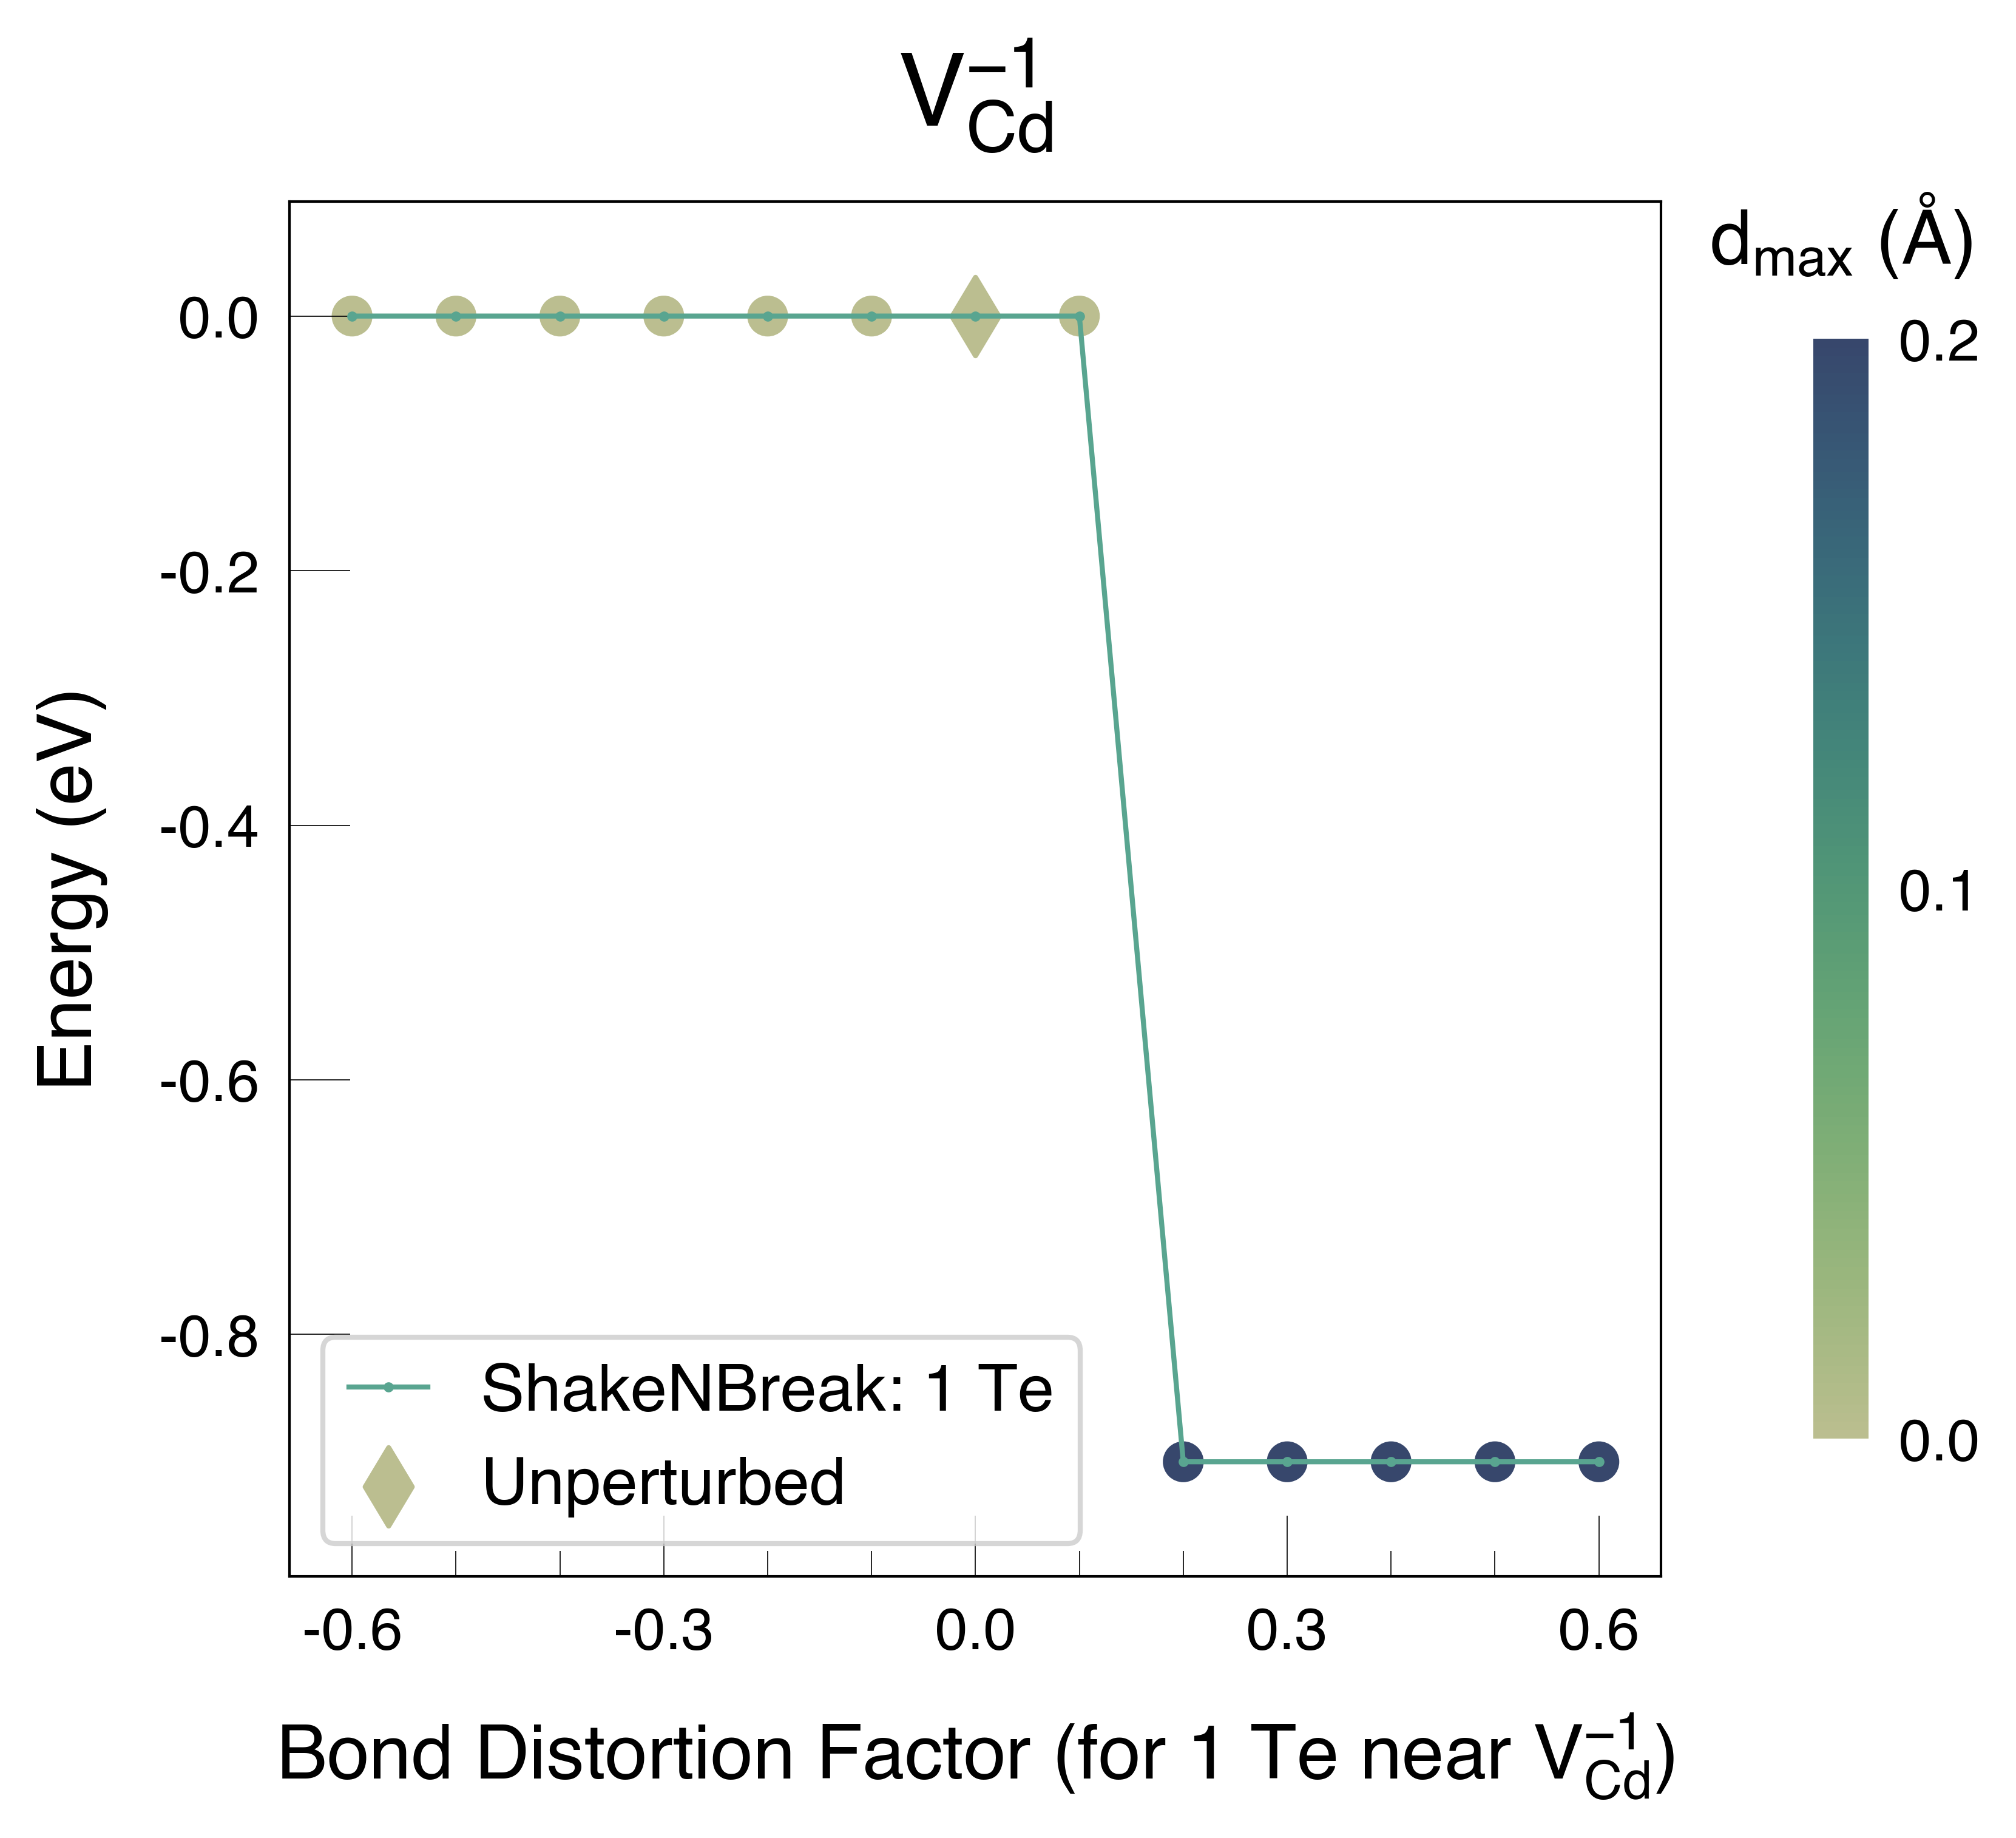

In [11]:
figs = plotting.plot_all_defects(defect_charges_dict,
                                add_colorbar=True)

Comparing structures to Unperturbed...
Plot saved to /Users/skavanagh/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Bread/Projects/Packages/ShakeNBreak/distortion_plots/
Comparing structures to Unperturbed...
Plot saved to /Users/skavanagh/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Bread/Projects/Packages/ShakeNBreak/distortion_plots/


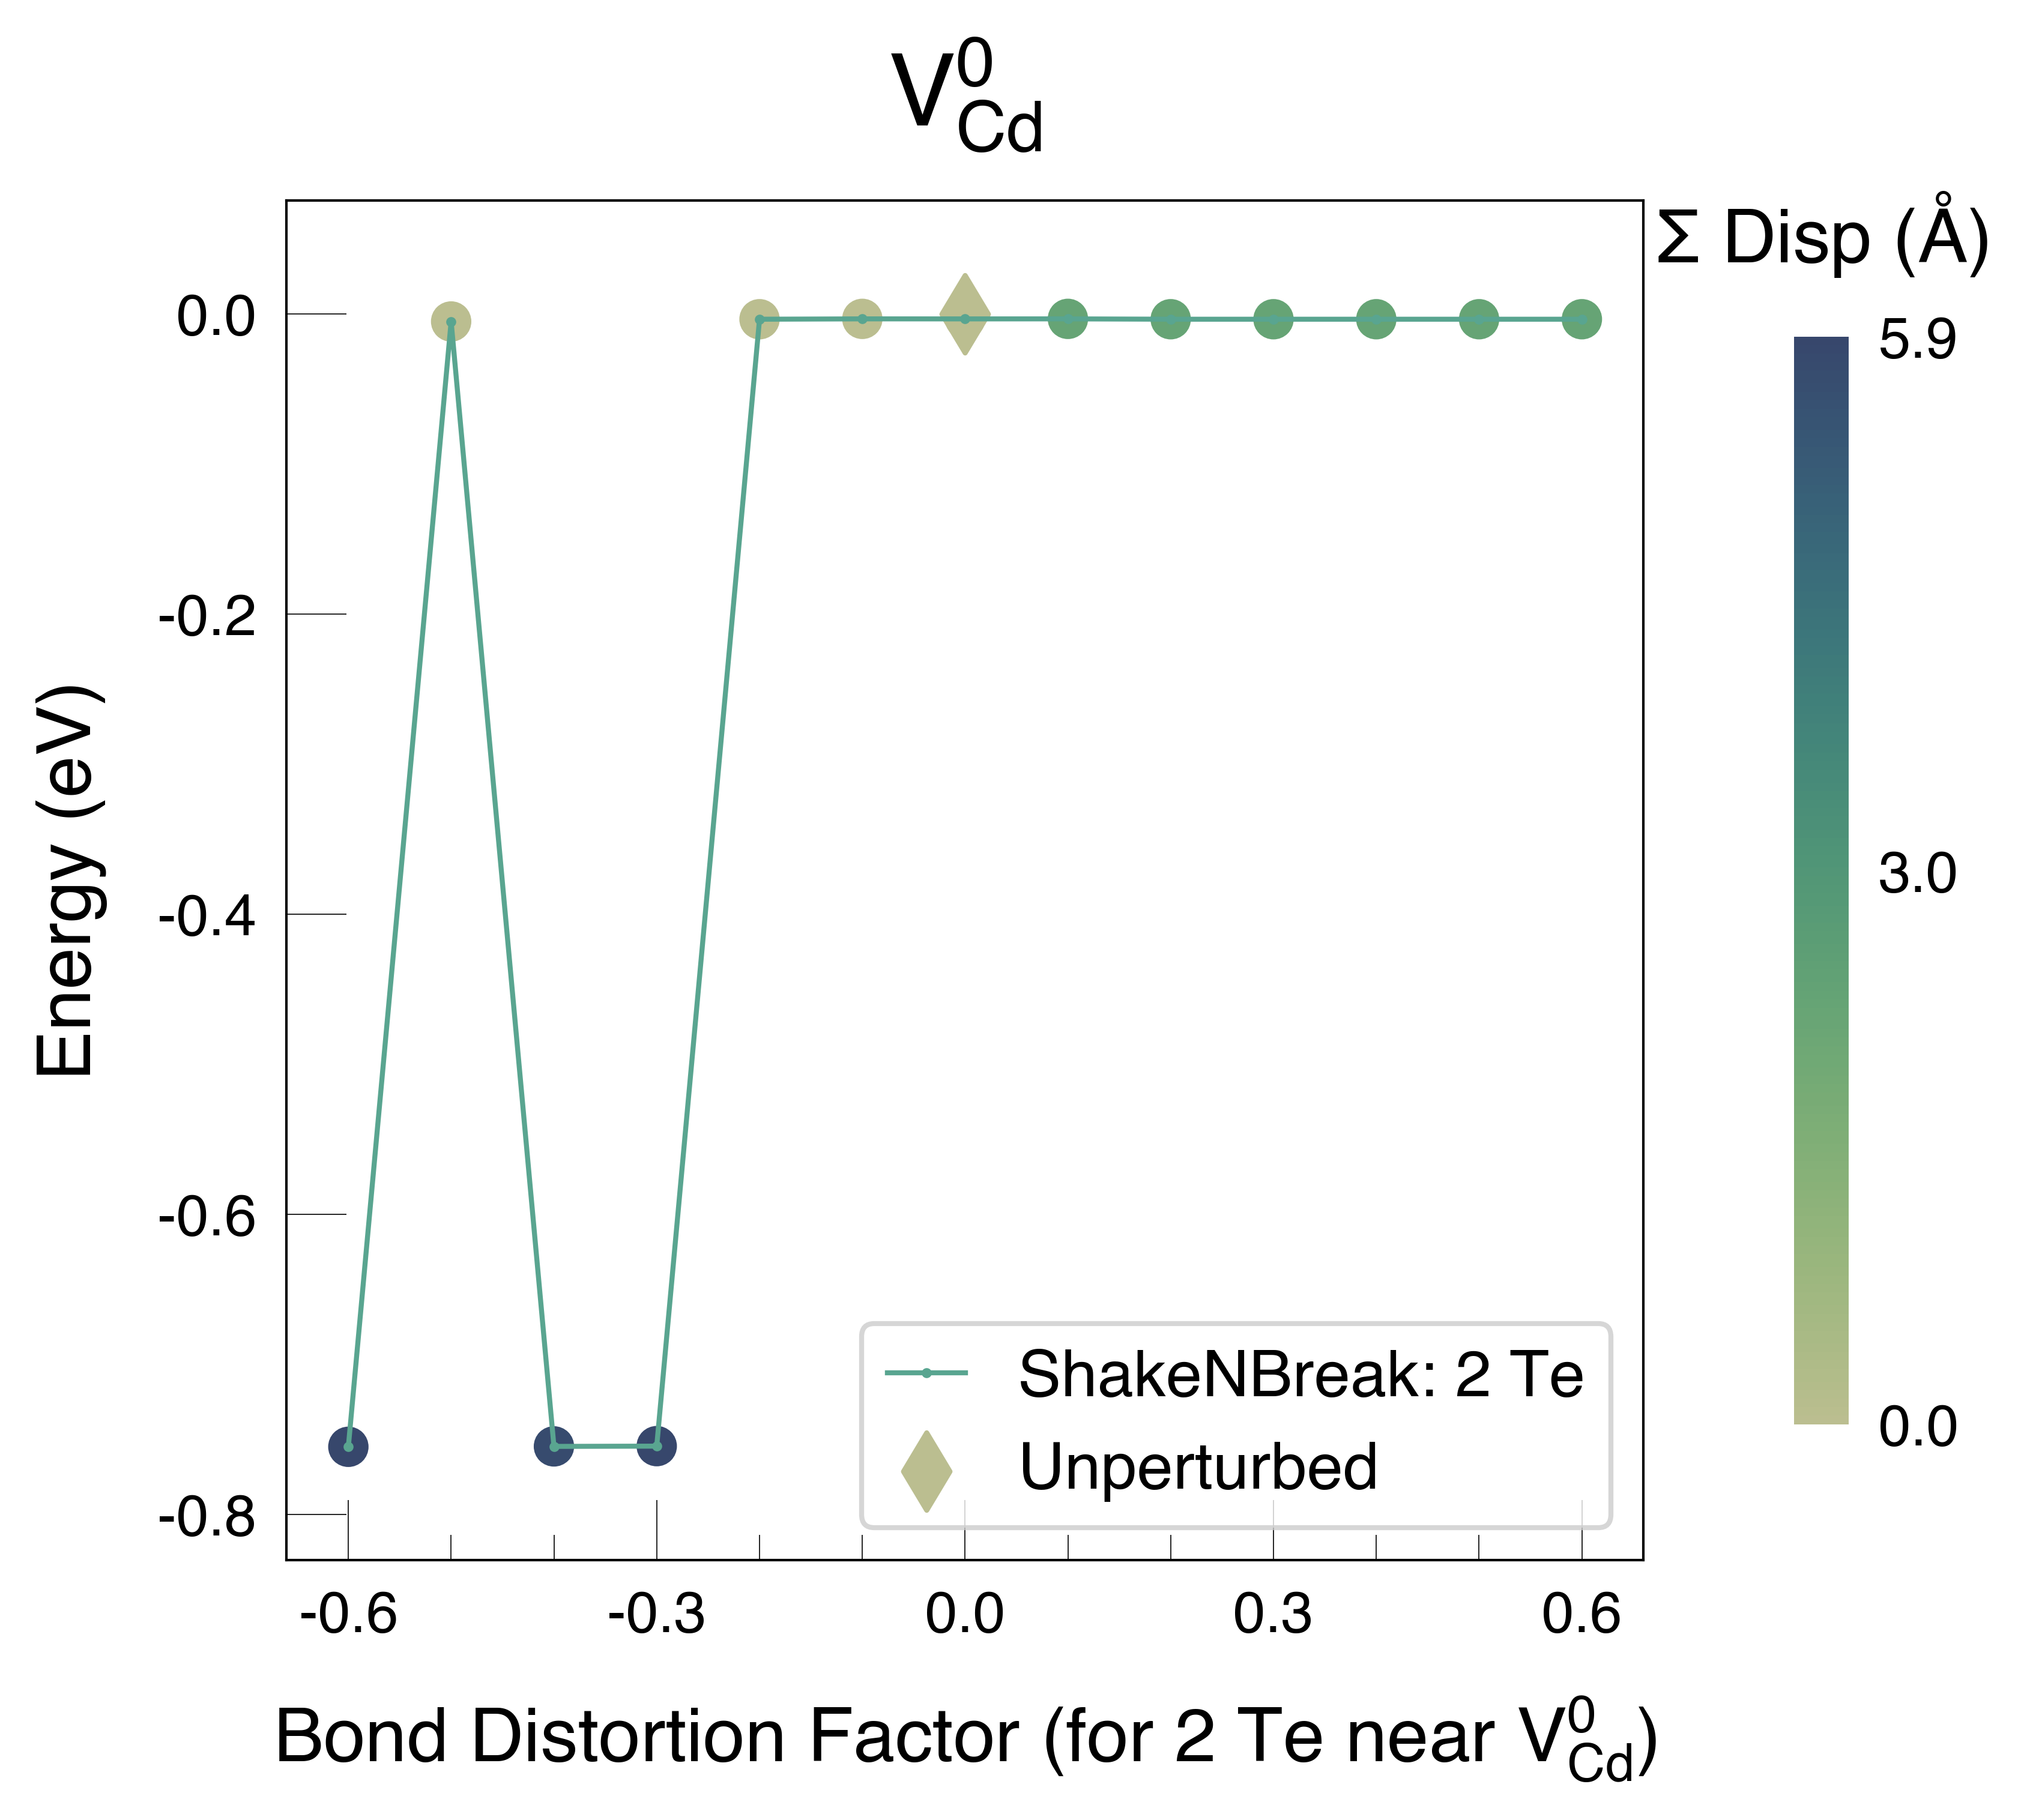

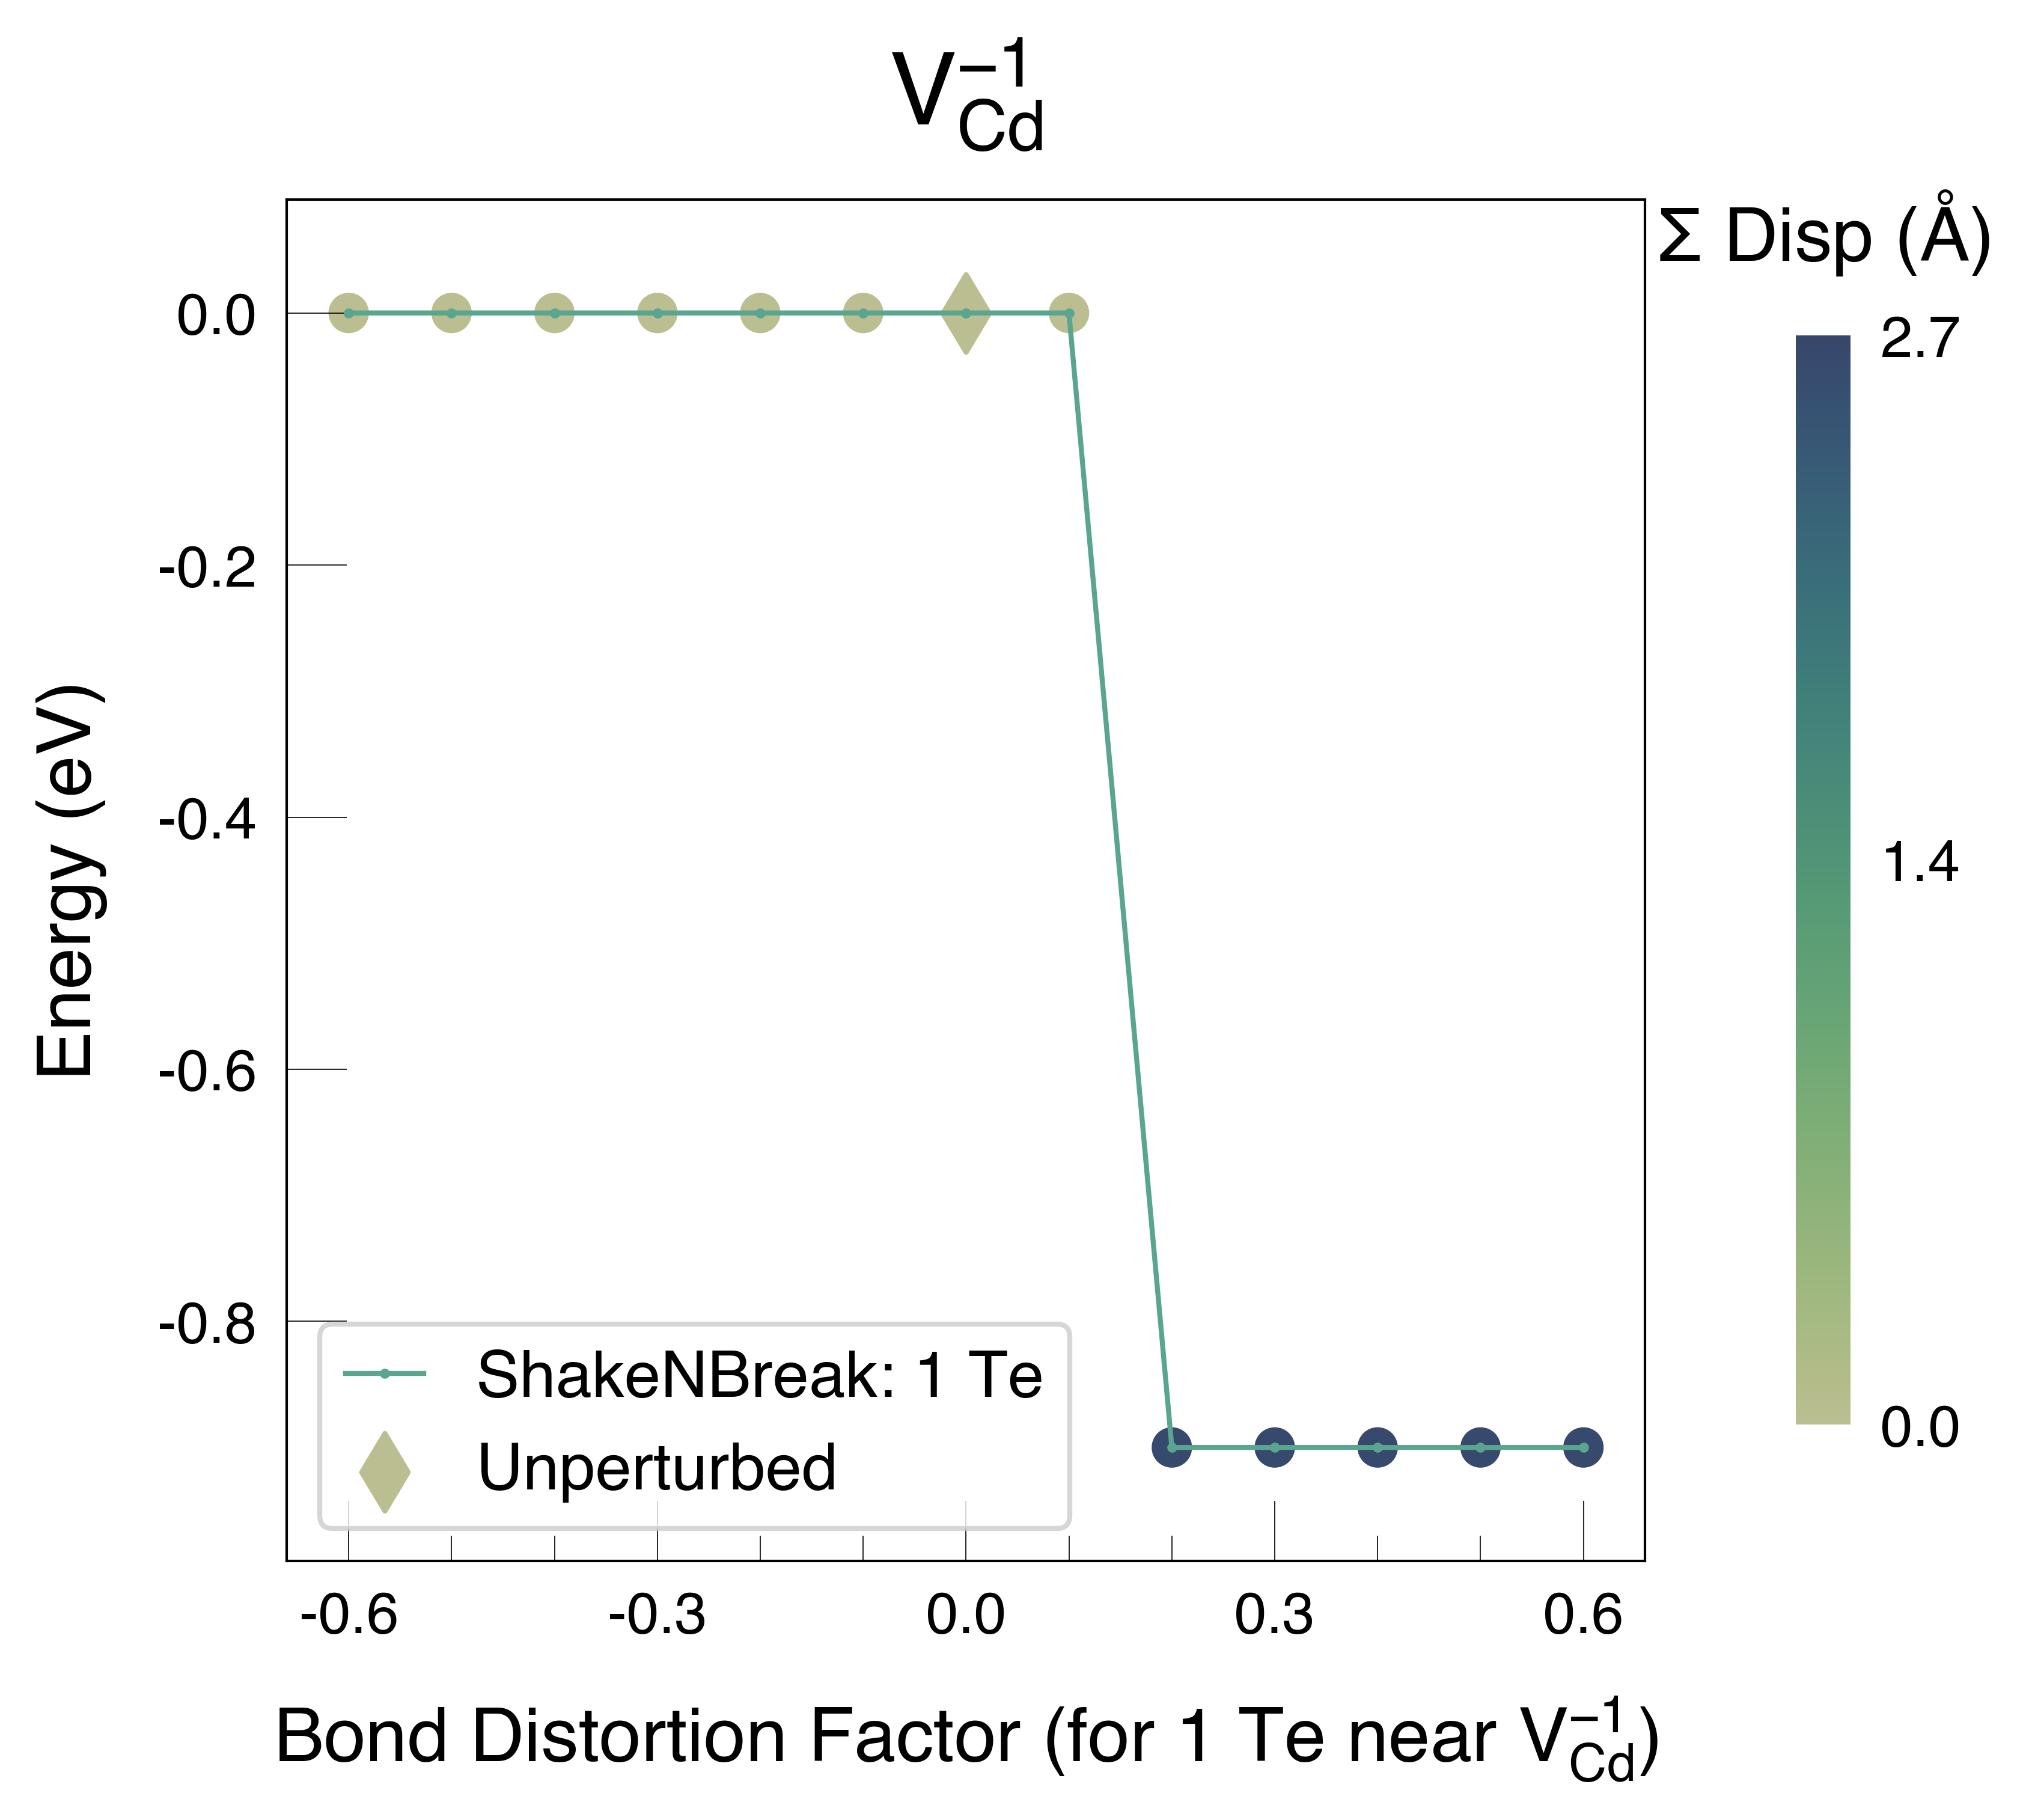

In [12]:
figs = plotting.plot_all_defects(defect_charges_dict,
                                add_colorbar=True,
                                metric="disp")

So for these example results, we find energy lowering distortions for $V_{Cd}^0$ (at -0.3, -0.4 and -0.6 bond distortion factors) and $V_{Cd}^{-1}$ (from 0.2 to 0.6 bond distortion factors). We should re-test these distorted structures for the $V_{Cd}$ charge states where these distortions were not found, in case they also give lower energies. 

Of course, this is not necessary if these structures were already found in the distortion tests for the other charge states, and so the `get_energy_lowering_distortions()` function automatically performs structure comparisons to determine which distortions should be tested in other charge states of the same defect, and which have already been found (see docstring and code paper for more details). 

In the output of `get_energy_lowering_distortions()` (which we saved to `low_energy_defects` in the earlier cell), we get a dictionary of defects for which bond distortion found an energy-lowering distortion (which is missed with normal unperturbed relaxation), of the form {defect: [list of distortion dictionaries (with corresponding charge states, energy lowering, distortion factors, structures and charge states for which these structures weren't found)]}.

For example, our results with $V_{Cd}$ show that we found an energy-lowering distortion for the neutral case (`charges`) which wasn't found with the -2 or -1 charge states (`excluded_charges`) – and so we'll test this distorted structures with those charge states – and also an energy-lowering distortion for -1 which wasn't found with 0 or -1 charge states.

In [13]:
for subdict in low_energy_defects["vac_1_Cd"]:
    print(subdict["charges"])
    print(subdict["excluded_charges"])

[0]
{-2, -1}
[-1]
{0, -2}


This generates the new distorted structures and VASP inputs, to do our quick second round of structure testing (energy-lowering distortions found for at least one, but not all charge states for a given defect):

In [14]:
energy_lowering_distortions.write_distorted_inputs(low_energy_defects)

Writing low-energy distorted structure to ./vac_1_Cd_-2/Bond_Distortion_-60.0%_from_0
Writing low-energy distorted structure to ./vac_1_Cd_-1/Bond_Distortion_-60.0%_from_0
Writing low-energy distorted structure to ./vac_1_Cd_0/Bond_Distortion_20.0%_from_-1
Writing low-energy distorted structure to ./vac_1_Cd_-2/Bond_Distortion_20.0%_from_-1


Again we run the calculations on the HPCs, then parse and download the data to our local folders (but again in this example notebook we'll use our fake example data **_for demonstration purposes_** as in the next cell, but don't do this if you're actually running the calculations!)

In [15]:
!cp ./vac_1_Cd_0/vac_1_Cd_0_additional_distortions.txt ./vac_1_Cd_0/vac_1_Cd_0.txt
!cp ./vac_1_Cd_-1/vac_1_Cd_-1_additional_distortions.txt ./vac_1_Cd_-1/vac_1_Cd_-1.txt
!cp ./vac_1_Cd_-2/vac_1_Cd_-2_additional_distortions.txt ./vac_1_Cd_-2/vac_1_Cd_-2.txt
!cp ./vac_1_Cd_0/Bond_Distortion_-60.0%/CONTCAR ./vac_1_Cd_-1/Bond_Distortion_-60.0%_from_0/
!cp ./vac_1_Cd_0/Bond_Distortion_-60.0%/CONTCAR ./vac_1_Cd_-2/Bond_Distortion_-60.0%_from_0/
!cp ./vac_1_Cd_-1/Unperturbed/CONTCAR ./vac_1_Cd_-2/Bond_Distortion_20.0%_from_-1/
!cp ./vac_1_Cd_-1/Unperturbed/CONTCAR ./vac_1_Cd_0/Bond_Distortion_20.0%_from_-1/

Then re-parse with the same `get_energy_lowering_distortions()` function from before:

In [17]:
low_energy_defects = energy_lowering_distortions.get_energy_lowering_distortions(
    defect_charges_dict)


vac_1_Cd
vac_1_Cd_-2: Energy difference between minimum, found with 20.0%_from_-1 bond distortion, and unperturbed: -1.90 eV.
Energy lowering distortion found for vac_1_Cd with charge -2. Adding to low_energy_defects dictionary.
vac_1_Cd_0: Energy difference between minimum, found with -0.6 bond distortion, and unperturbed: -0.76 eV.
Comparing structures to specified ref_structure (Cd31 Te32)...
New (according to structure matching) low-energy distorted structure found for vac_1_Cd_0, adding to low_energy_defects['vac_1_Cd'] list.
vac_1_Cd_-1: Energy difference between minimum, found with -60.0%_from_0 bond distortion, and unperturbed: -1.20 eV.
Comparing structures to specified ref_structure (Cd31 Te32)...
Comparing structures to specified ref_structure (Cd31 Te32)...
Low-energy distorted structure for vac_1_Cd_-1 already found with charge states [0], storing together.

Comparing and pruning defect structures across charge states...
Comparing structures to specified ref_structure (Cd

Finally we can replot the results from all our distortion tests:

vac_1_Cd_-2: Energy difference between minimum, found with 20.0%_from_-1 bond distortion, and unperturbed: -1.90 eV.
Plot saved to /Users/skavanagh/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Bread/Projects/Packages/ShakeNBreak/distortion_plots/
Plot saved to /Users/skavanagh/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Bread/Projects/Packages/ShakeNBreak/distortion_plots/


{'vac_1_Cd_0': <Figure size 3600x3000 with 1 Axes>,
 'vac_1_Cd_-1': <Figure size 3600x3000 with 1 Axes>}

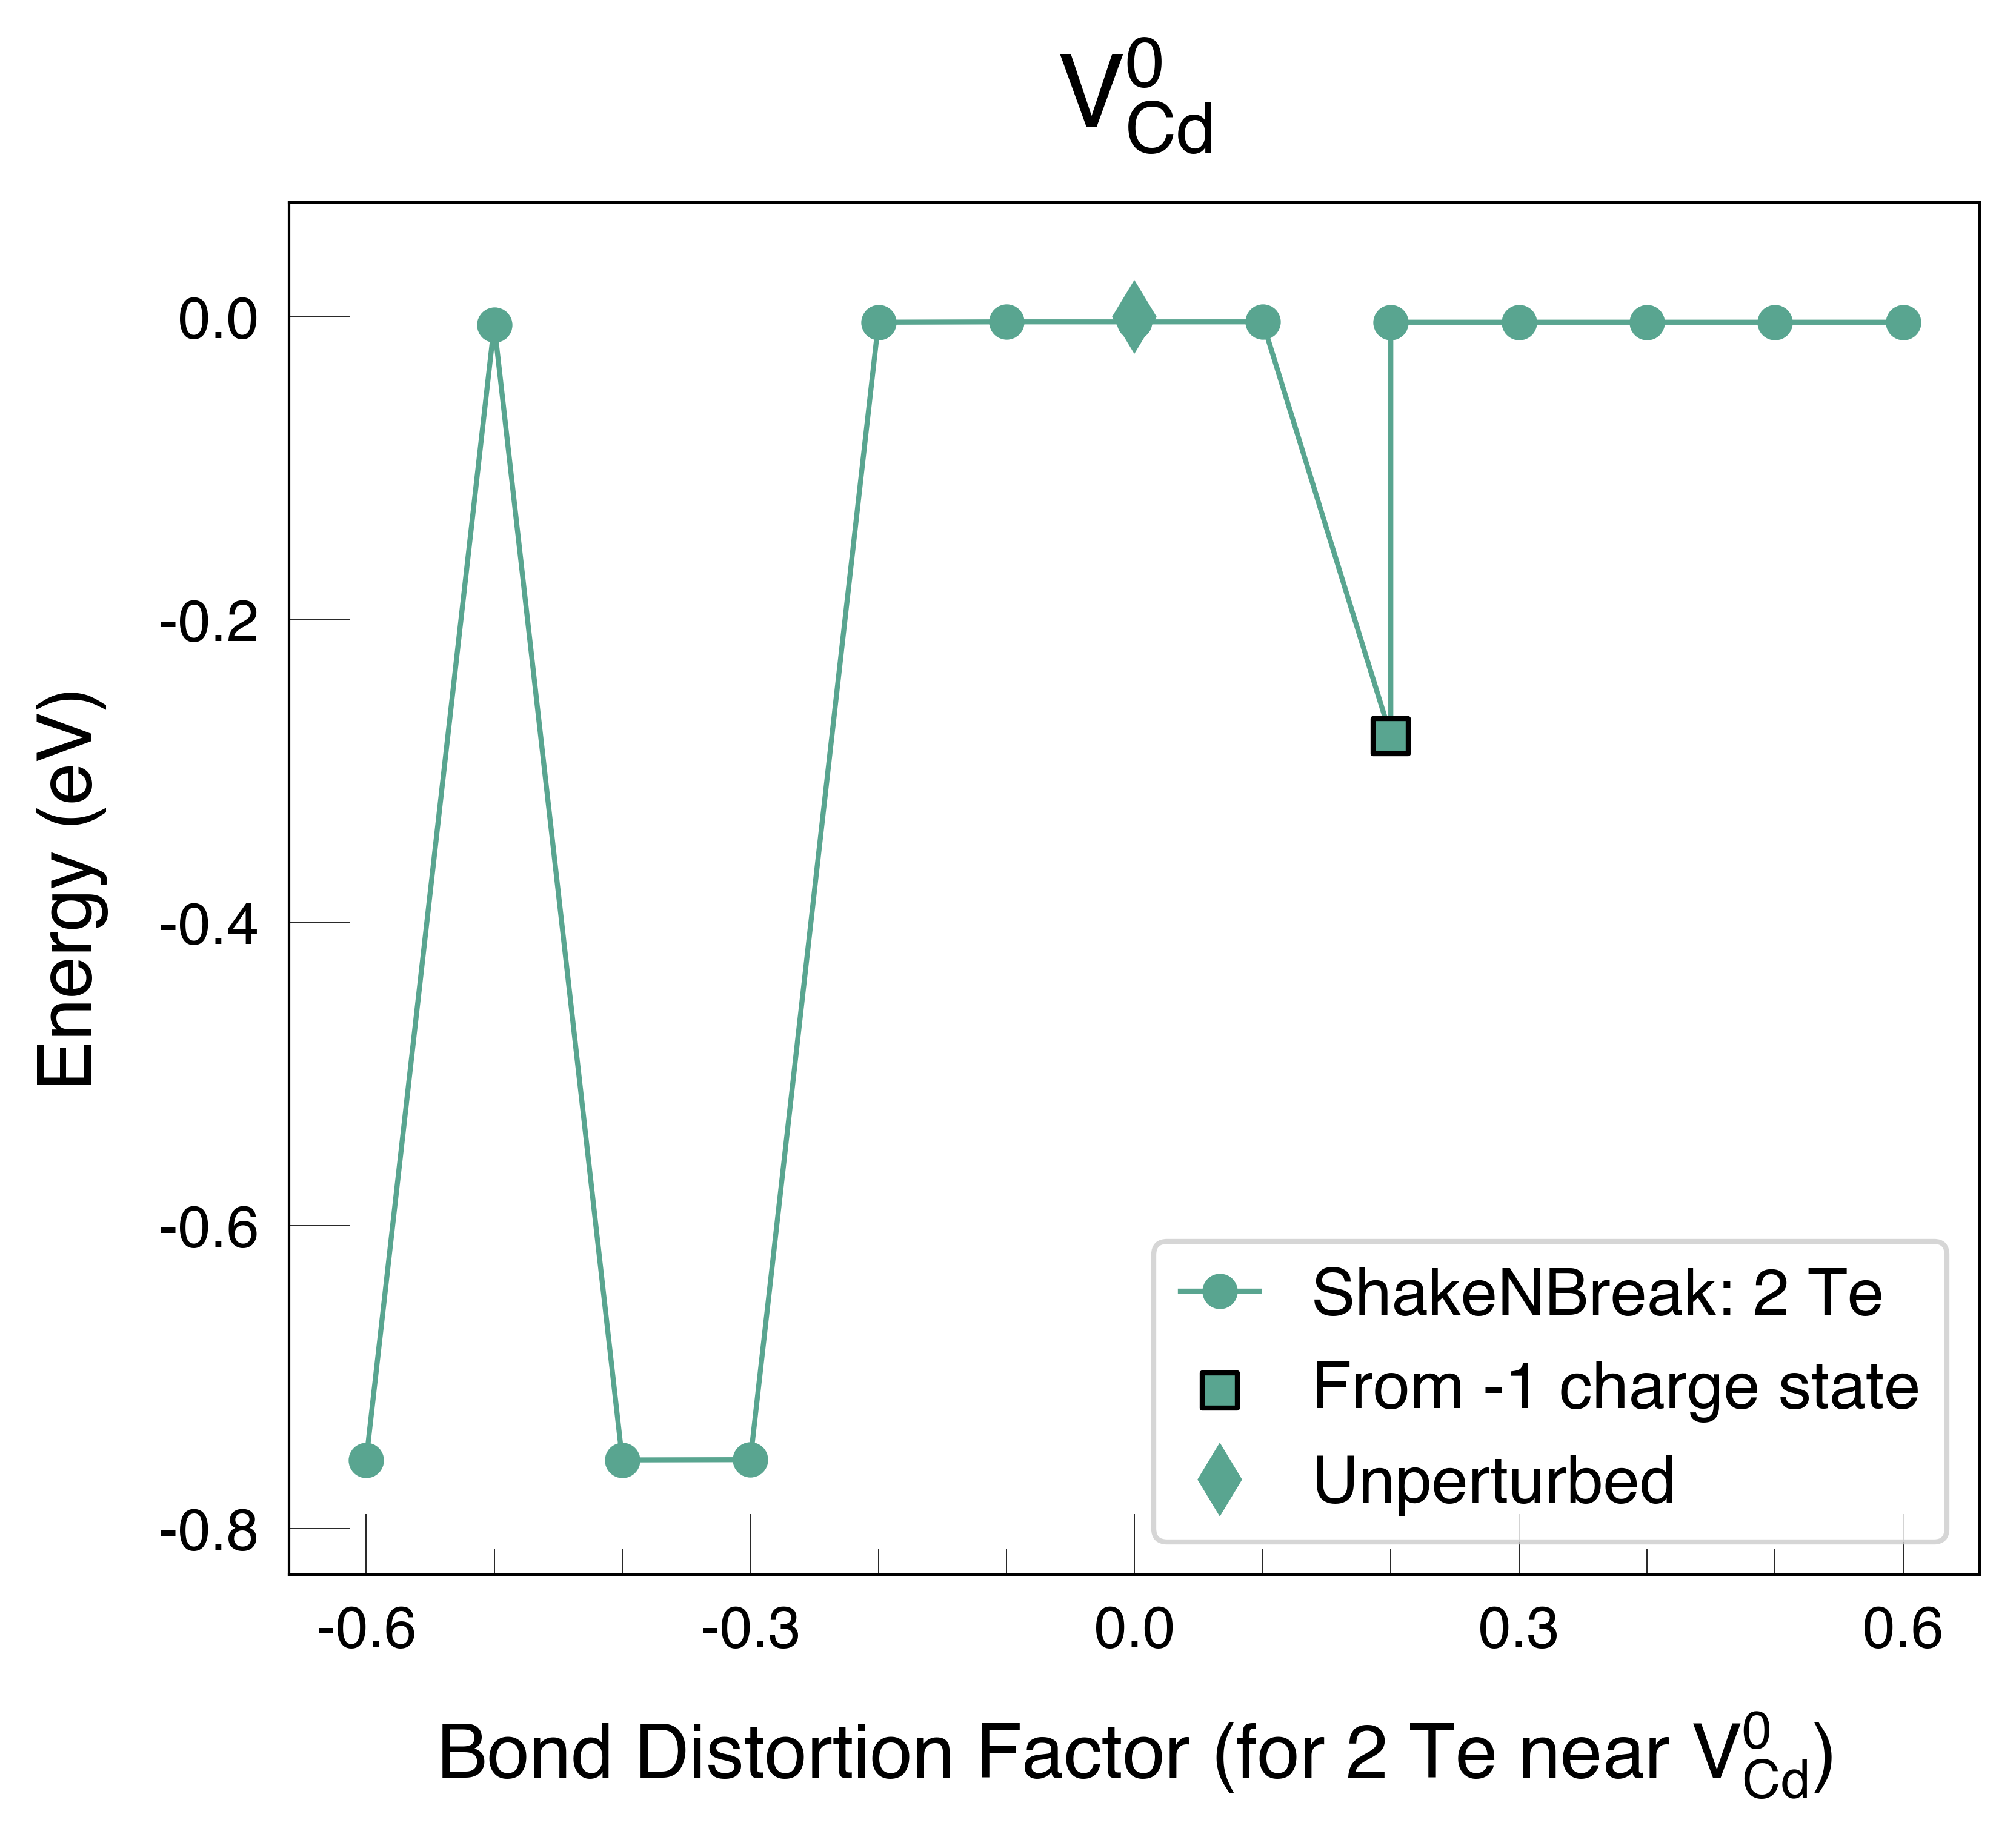

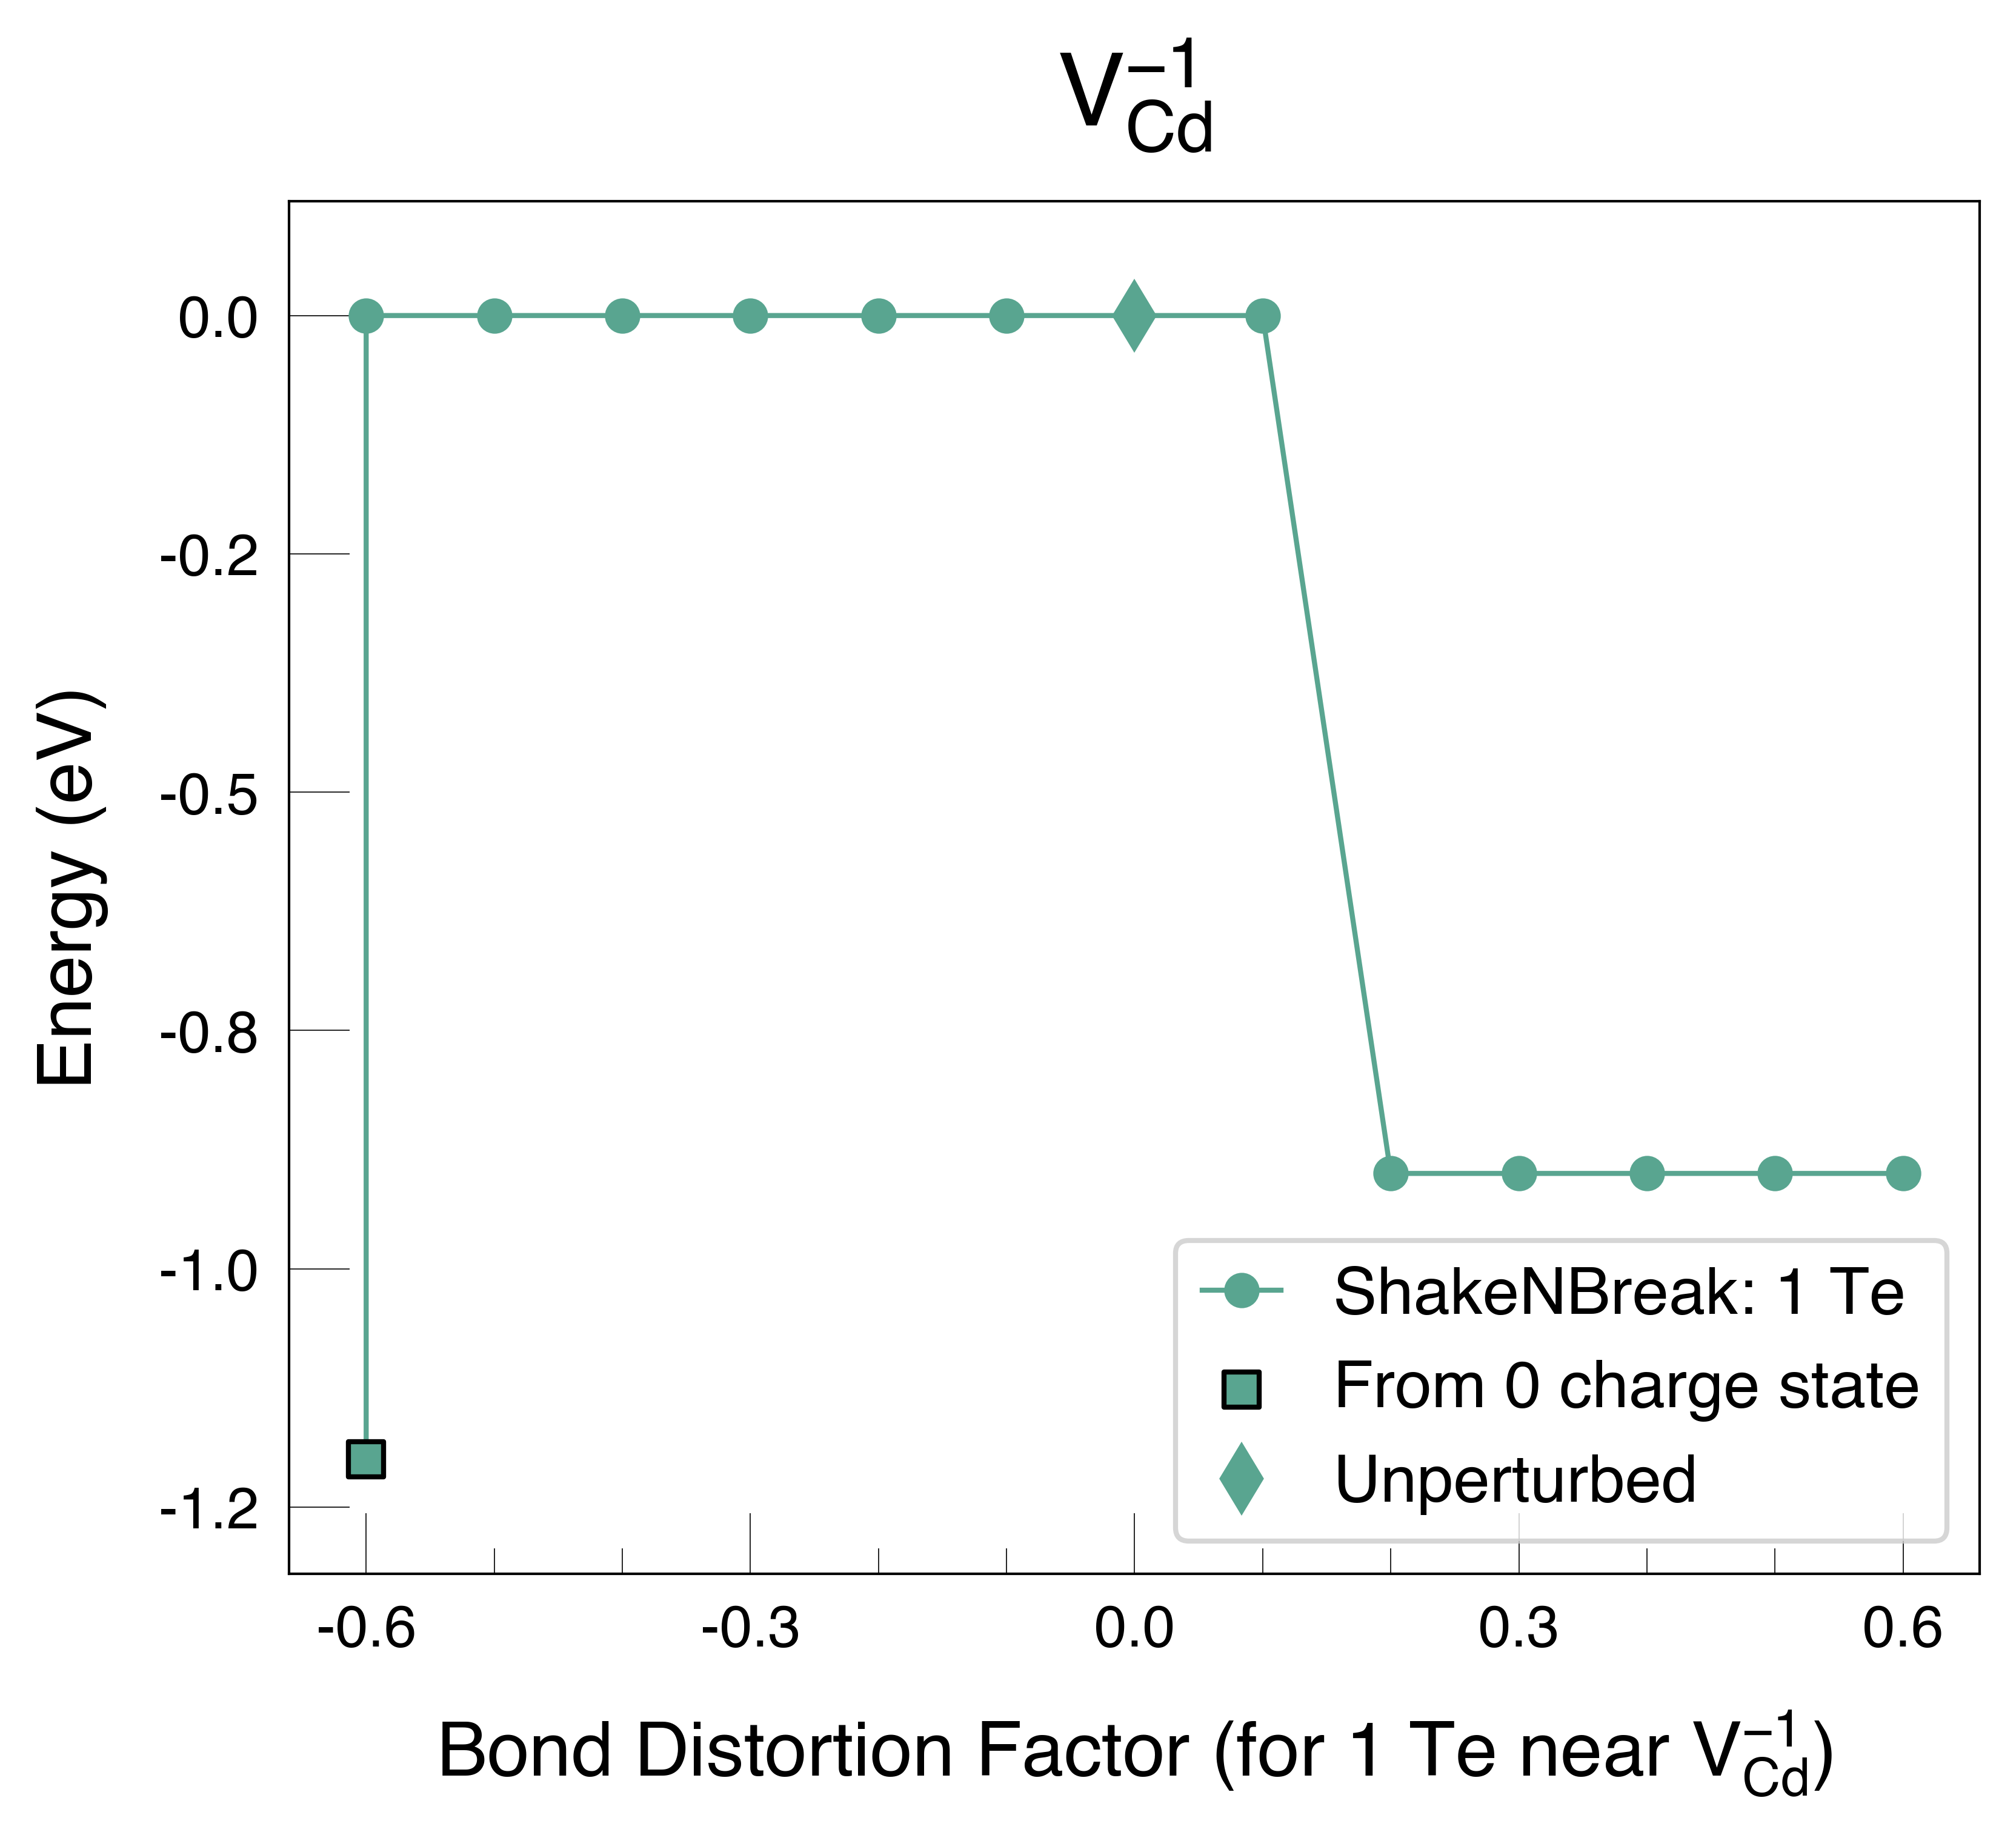

In [18]:
plotting.plot_all_defects(defect_charges_dict)

In this example case, for $V_{Cd}^{0}$ the distorted structure originally found for the -1 charge state comes out lower energy than the $V_{Cd}^{0}$ unperturbed relaxation, but still higher energy than the previously identified ground-state at -0.3, -0.4 and -0.6 distortion factors. 

For $V_{Cd}^{-1}$, the distorted structure originally found for the neutral (0) charge state comes out lower energy than the previously identified ground-state at distortion factors >0.2.

We now continue our defect calculations using the ground-state `CONTCAR`s we've obtained for each defect, with our fully-converged `INCAR` and `KPOINTS` settings.

<a id='analyse'></a>

#### 5. Optional: Analyse the defect distortions found with `SnB`

If we want to analyse in more detail the defect distortions identified with our structure searching, we can use some of the functions from `shakenbreak.analysis`:

In [4]:
from shakenbreak import analysis

# Parse all structures obtained with distortions and unperturbed relaxation.   
# This gives a dictionary matching initial distortion to final structure
vac_1_Cd_0 = analysis.get_structures("vac_1_Cd_0")

In [22]:
# Can then analyse a chosen final structure with:
analysis.analyse_structure("vac_1_Cd_0", vac_1_Cd_0["Unperturbed"])
analysis.analyse_structure("vac_1_Cd_0", vac_1_Cd_0[-0.4]);

==>  vac_1_Cd_0 structural analysis   <==
Analysing site V [0. 0. 0.]
Local order parameters (i.e. resemblance to given structural motif, via CrystalNN):


,Coordination,Factor
0,square co-planar,0.085138
1,tetrahedral,0.999723
2,rectangular see-saw-like,0.008200
3,see-saw-like,0.241093
4,trigonal pyramidal,0.252129



Bond-lengths (in Å) to nearest neighbours: 


,Element,Distance
0,Te,2.597
1,Te,2.627
2,Te,2.627
3,Te,2.652



==>  vac_1_Cd_0 structural analysis   <==
Analysing site V [0. 0. 0.]
Local order parameters (i.e. resemblance to given structural motif, via CrystalNN):


,Coordination,Factor
0,square co-planar,0.125216
1,tetrahedral,0.737708
2,rectangular see-saw-like,0.030893
3,see-saw-like,0.205372
4,trigonal pyramidal,0.213782



Bond-lengths (in Å) to nearest neighbours: 


,Element,Distance
0,Te,2.192
1,Te,2.635
2,Te,2.635
3,Te,2.296


We can also compare the structural similarity between all structures with `compare_structures()`. It prints the summed root mean squared displacement,
maximum distance between paired sites, and energy (relative to unperturbed structure) of all final structures:

In [23]:
defect_energies = analysis.get_energies("vac_1_Cd_0")
structure_comparison = analysis.compare_structures(
    vac_1_Cd_0, 
    defect_energies)

vac_1_Cd_0: Energy difference between minimum, found with -0.6 bond distortion, and unperturbed: -0.76 eV.
Comparing structures to Unperturbed...


,Bond Distortion,Σ{Displacements} (Å),Max Distance (Å),Δ Energy (eV)
0,-0.6,5.873,0.810,-0.76
1,-0.5,0.000,0.024,-0.01
2,-0.4,5.760,0.808,-0.75
3,-0.3,5.872,0.808,-0.75
4,-0.2,0.000,0.025,0.00
5,-0.1,0.000,0.028,0.00
6,0.0,0.000,0.030,0.00
7,0.1,2.285,0.237,0.00
8,0.2,2.285,0.237,0.00
9,0.3,2.285,0.237,0.00


Highly favourable distortions are often driven by some kind of rebonding. For most vacancies and interstitials, this entails formation of new homoionic bonds between the defect neighbours.
We can quickly check for these reconstructions using `analysis.get_homoionic_bonds()`

In [21]:
bonds = analysis.get_homoionic_bonds(
    structure=vac_1_Cd_0[-0.4], # Structure to analyse
    element="Te", # we're looking for Te-Te bonds
    radius=2.8, # maximum bond distance between 2 Te
    verbose=False, # don't print bond distances
)
print(bonds)
print("So two of the vacancy neighbours formed a Te-Te bond to compensate for the charge deficiency")

{'Te(32)': {'Te(41)': '2.75 A'}}
So two of the vacancy neighbours formed a Te-Te bond to compensate for the charge deficiency


For defects that can result in polarons, we can check the sites with significant magnetization using `analysis.get_site_magnetizations()`

In [17]:
df = analysis.get_site_magnetizations(
    defect_species="vac_1_Ti_0", # neutral Ti vacancy in anatase TiO2
    distortions=["Unperturbed", -0.4],
    defect_site=[0.0, 0.16666666666666669, 0.25], 
    threshold=0.3, # to filter sites with significant magnetization
    orbital_projections=False, # don't show orbital projections
)

display(df["Unperturbed"]) # 4 holes localised on 4 of the vacancy neighbours
print("So we have 4 holes localised on 4 of the oxygen ions neighbouring the vacancy")

Analysing distortion Unperturbed. Total magnetization: 4.0
Analysing distortion -0.4. Total magnetization: -0.0
No significant magnetizations found for distortion: -0.4 



,Site,Coords,Total mag,Dist. (A)
O(35),O(35),"[0.0, 0.167, 0.014]",1.458,2.3
O(53),O(53),"[-0.0, 0.167, 0.486]",1.478,2.3
O(62),O(62),"[0.165, 0.167, 0.292]",1.522,1.9
O(68),O(68),"[0.835, 0.167, 0.292]",1.521,1.9


So we have 4 holes localised on 4 of the oxygen ions neighbouring the vacancy


As printed below, no significant magnetization is found for -40.0% distortion. This configuration was found to be significantly more stable than the polaronic solution, so we can quickly use `analysis.get_homoionic_bonds` to see why:

In [20]:
bonds = analysis.get_homoionic_bonds(
    structure = Structure.from_file("./vac_1_Ti_0/Bond_Distortion_-40.0%/CONTCAR"),
    element="O",
    radius=2.0,
    verbose=False,
)
print(bonds)
print("So the formation of an O-O bond drived this distortion")

{'O(44)': {'O(62)': '1.2 A'}}
So the formation of an O-O bond drived this distortion


See docstrings for more info and optional parameter choices etc